In [2]:
import numpy as np
import pandas as pd
import h5py
import pyBigWig
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
import torch

# Get data

In [2]:
# parameters
genome = 'mm10'
window_kb = 5

# load promoters
infile_promoter = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{window_kb}kb_filtered_clustered.bed"
promoterome = pd.read_csv(infile_promoter ,sep='\t')
CHR = promoterome.chr.unique()

# load chip table
infile=f"../resources/experimentList_{genome}_TFs_only_QC_filtered.tab"
experiment_tf = pd.read_csv(infile,sep='\t',usecols=[0,3])
experiment_tf.columns = ['id','antigen']

TFs = experiment_tf.antigen.unique()


# Peak score distribution

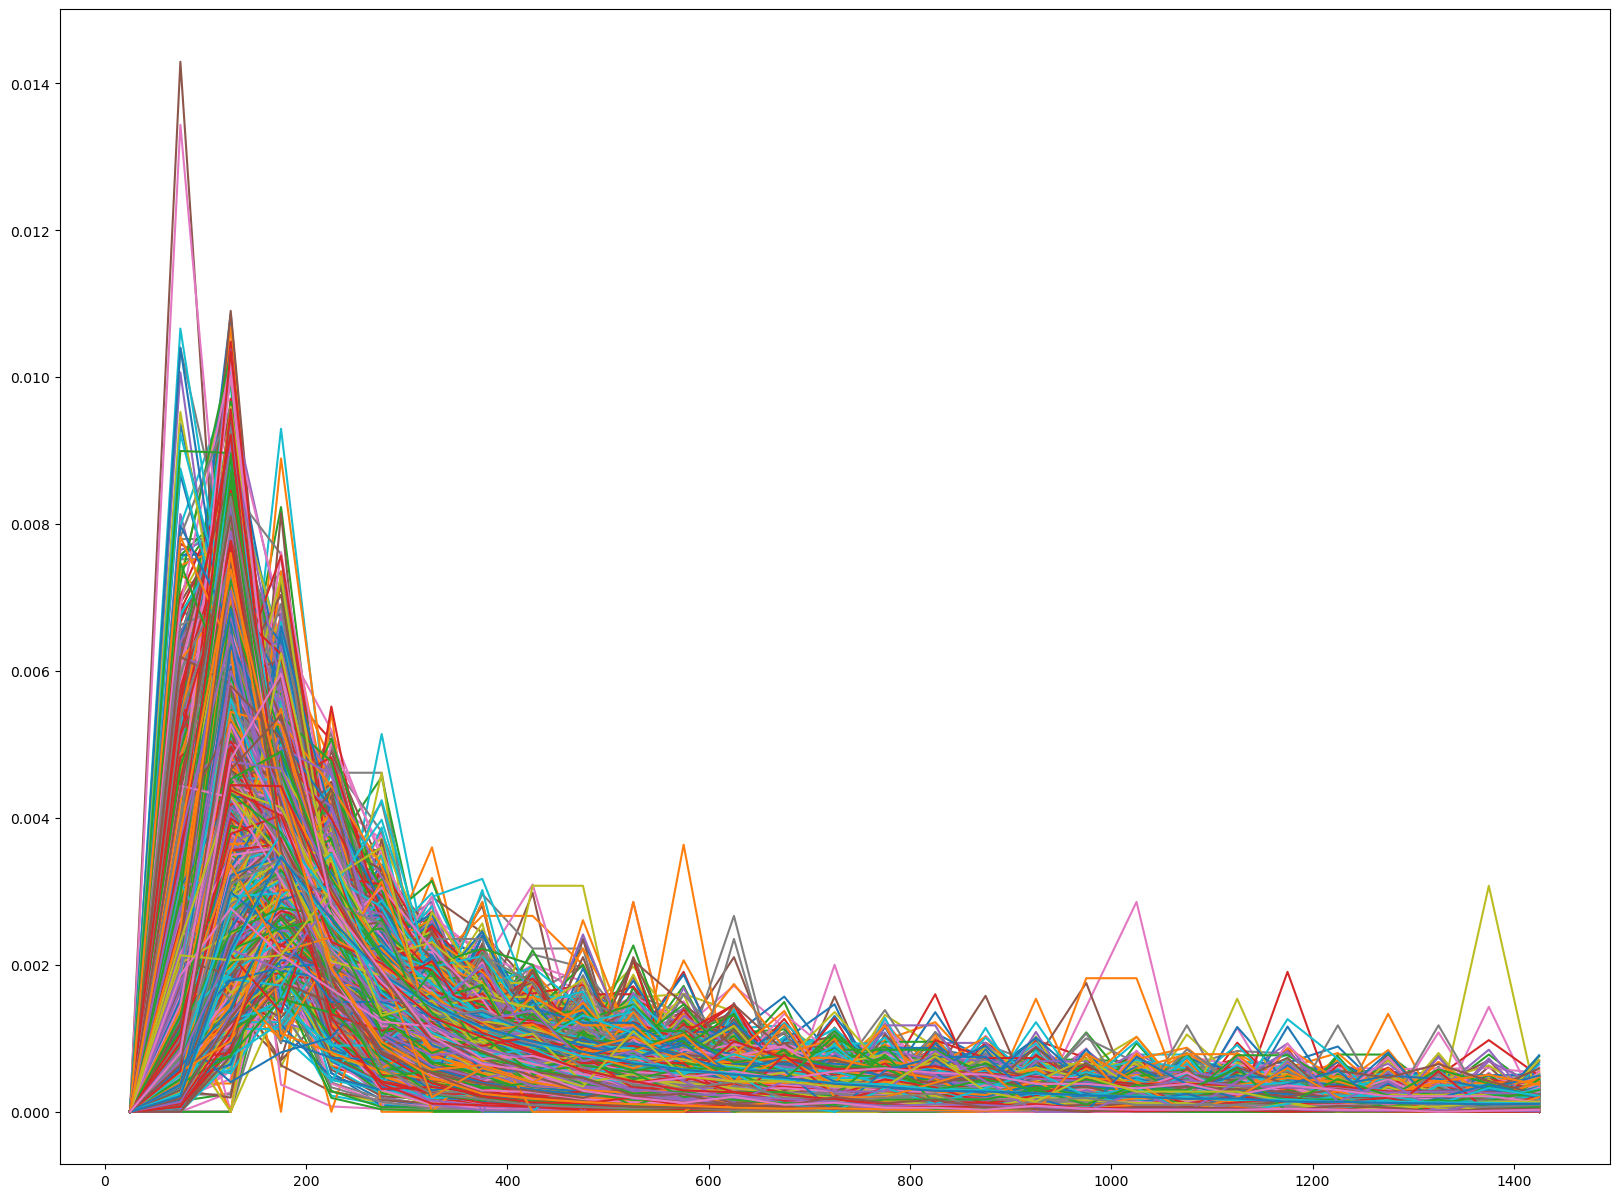

In [5]:
# look at score distribution per experiment

# get experiment ids
fig, ax = plt.subplots(1,1,figsize=(20,15))
for tf in TFs:
    IDs = list(experiment_tf.loc[experiment_tf.antigen==tf,'id'])

    for id in IDs:
        infile = f"../resources/tracks/mm10/{id}.05.bb"
        with pyBigWig.open(infile) as bb:
            entries = []
            for chr in CHR:
                if chr in bb.chroms():
                    start = 0
                    end = bb.chroms(chr)
                    vals = bb.entries(chr, start, end)
                    entries.extend( [int(v[2]) for v in vals] )

        [h,x] = np.histogram(entries, bins=np.arange(0,1500,50),density=True)
        x = .5*(x[:-1]+x[1:])
        ax.plot(x,h,label=id)




# Get TF x prom x pos peaks

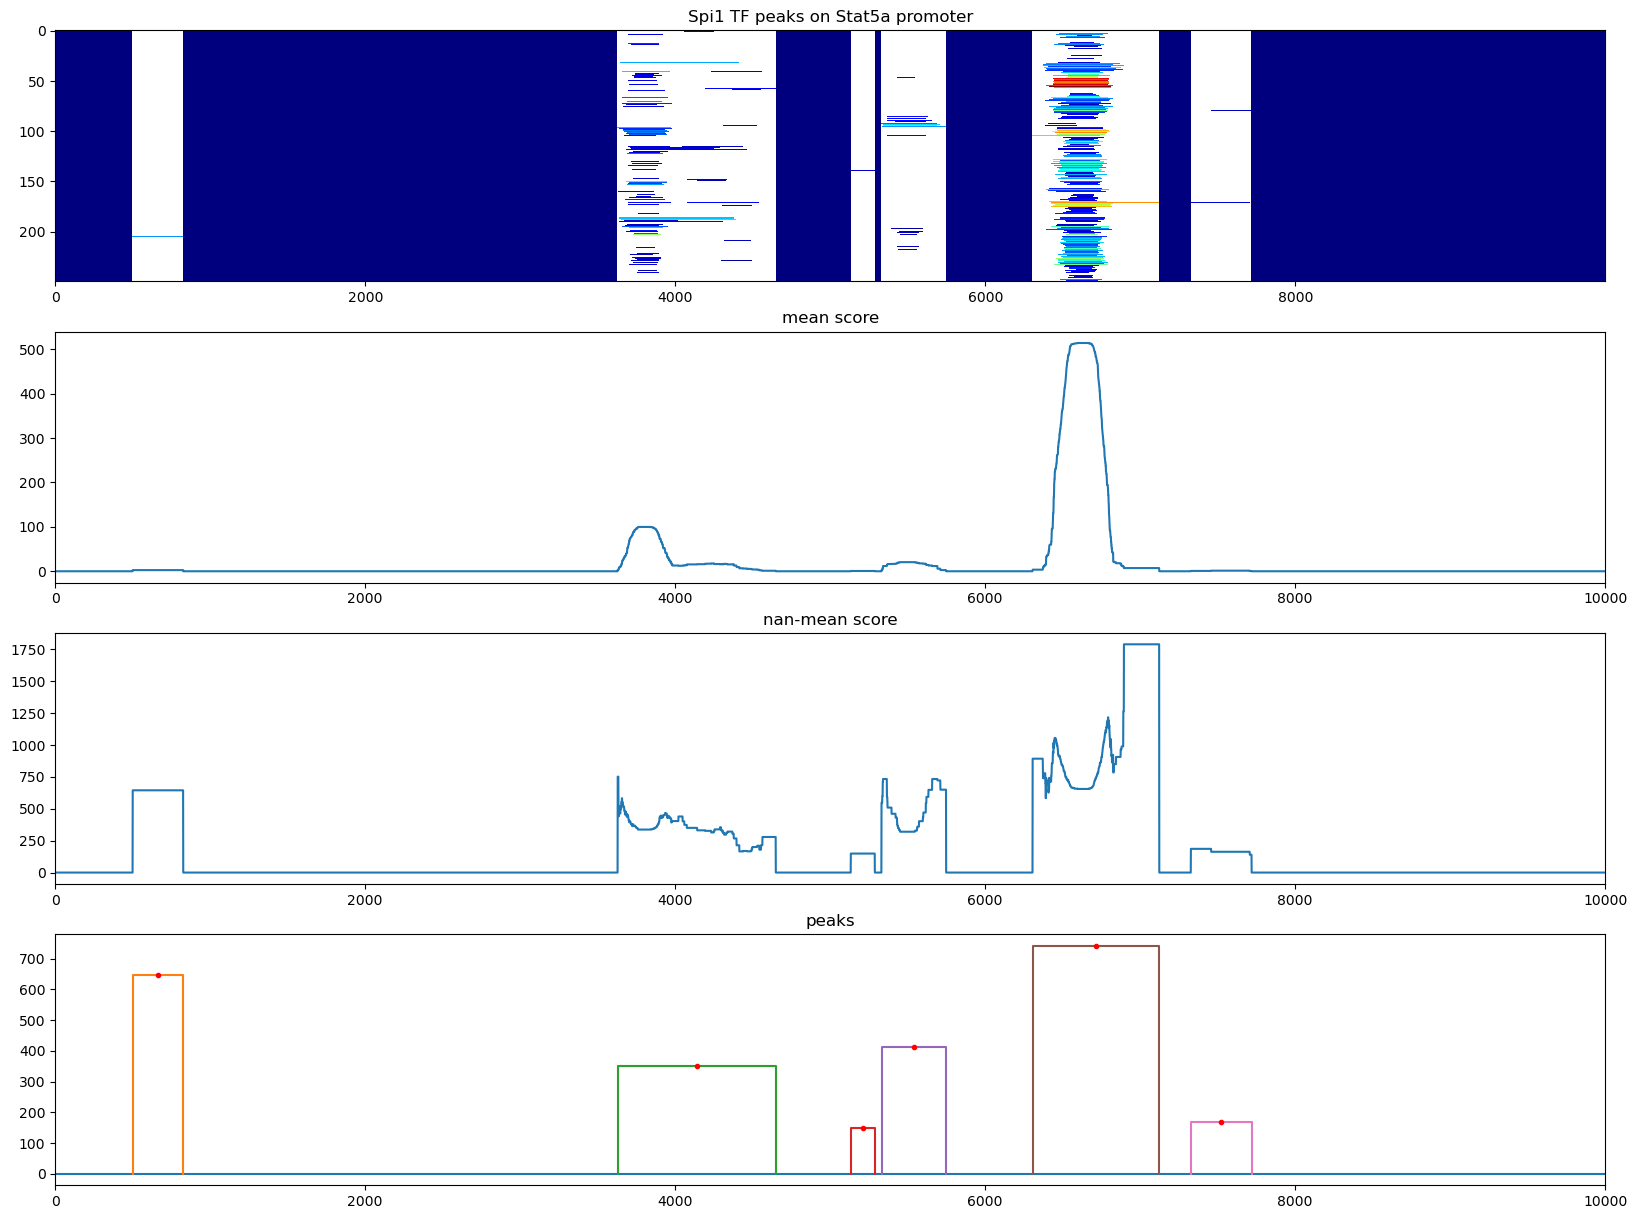

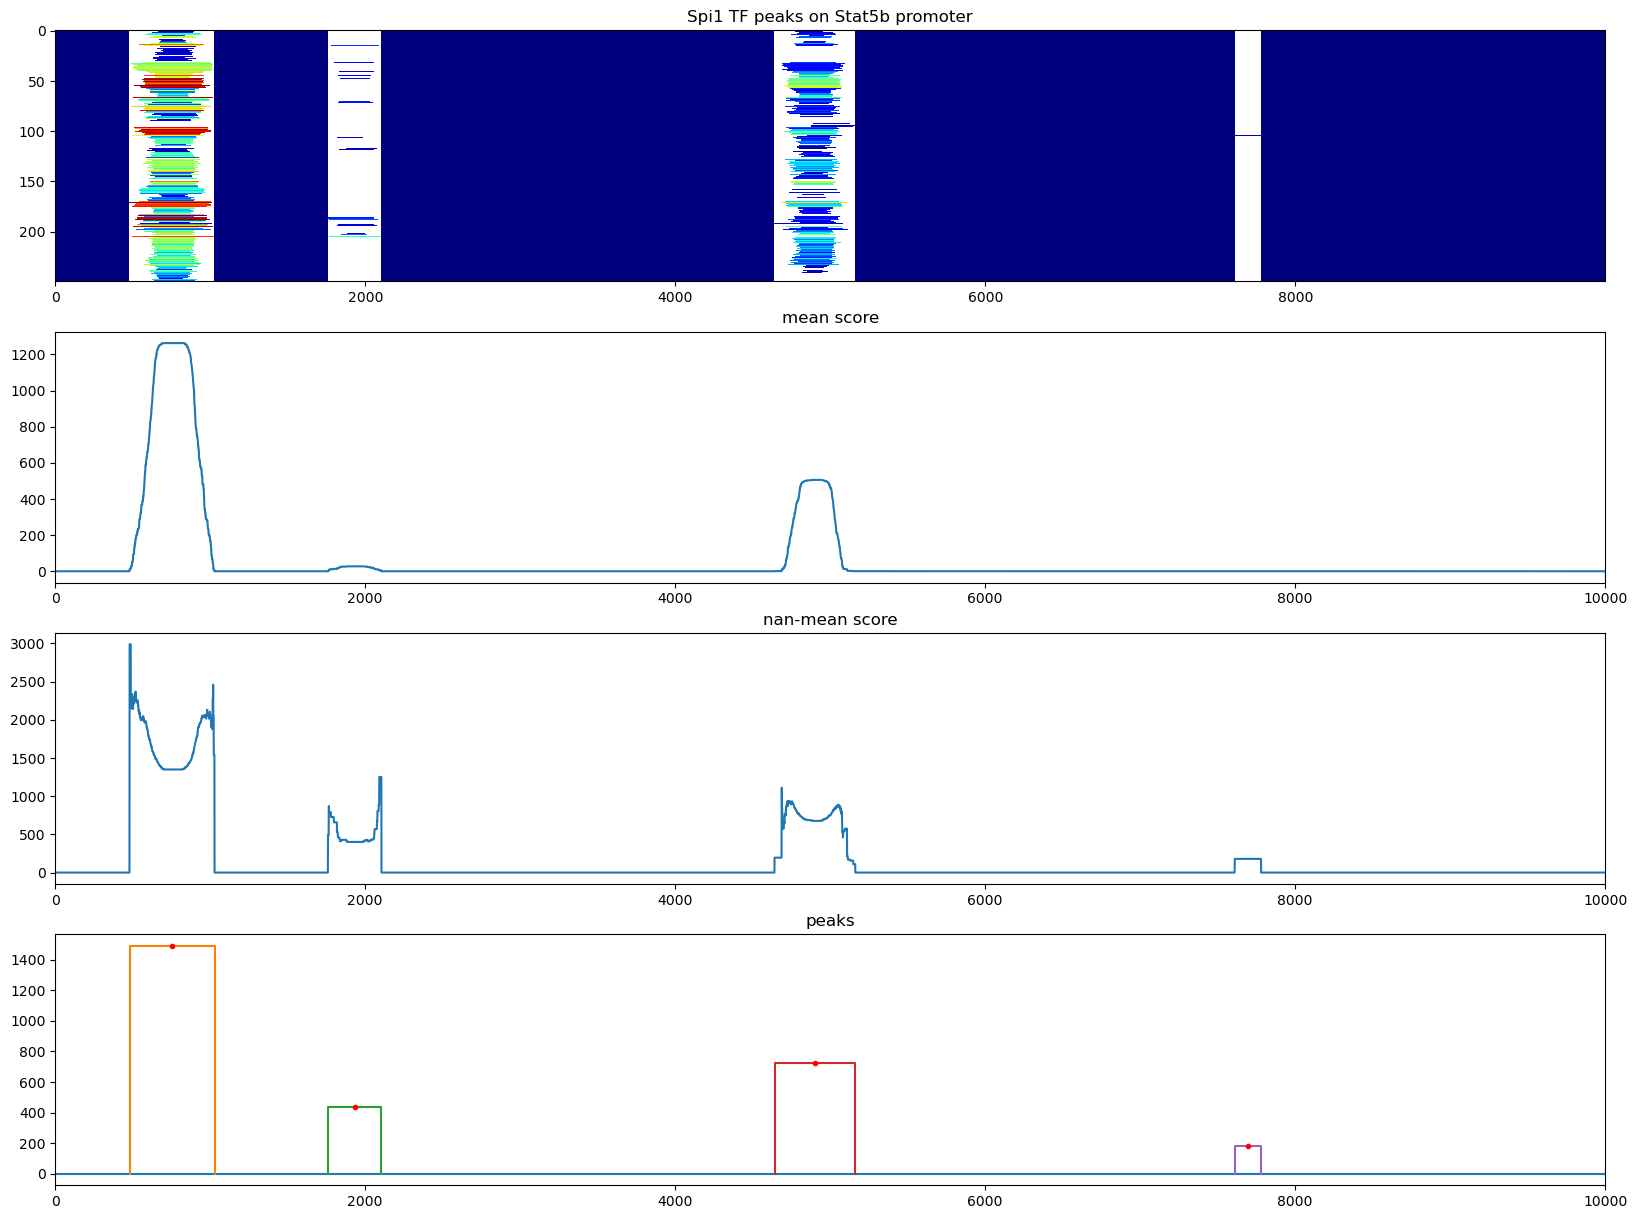

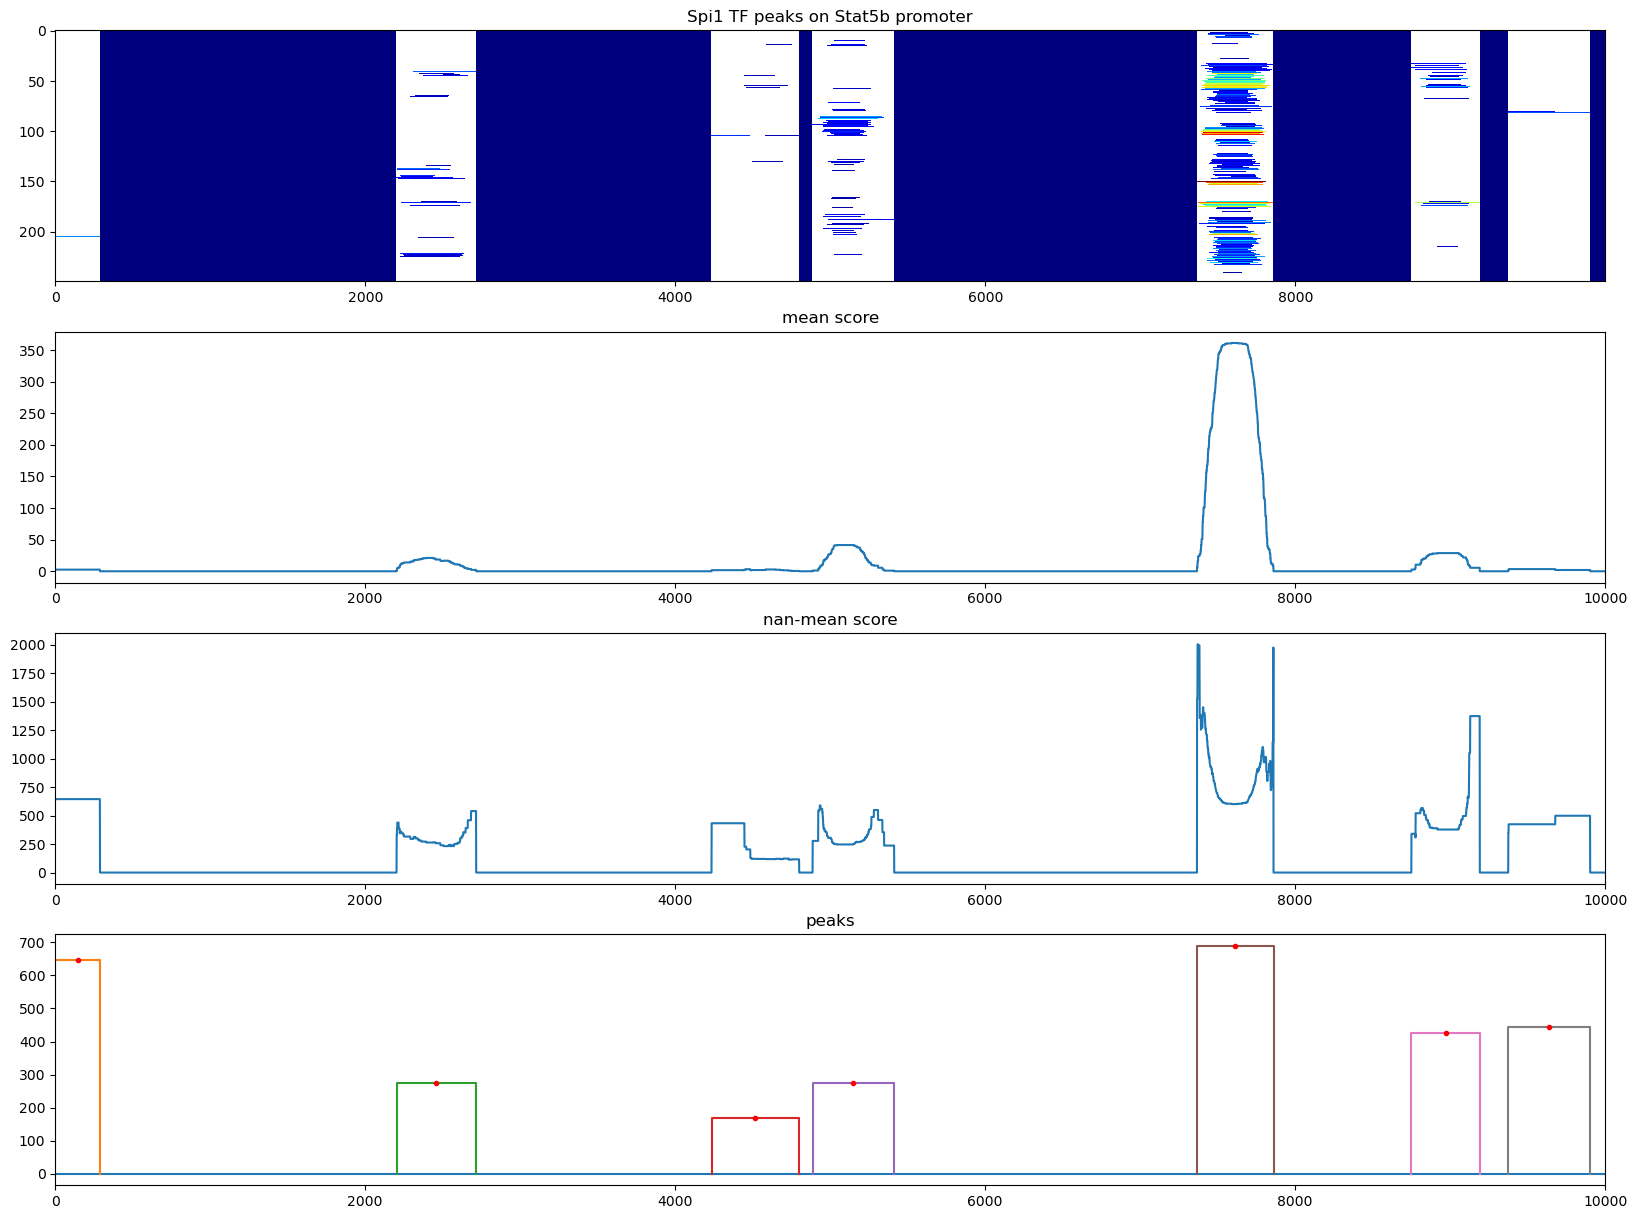

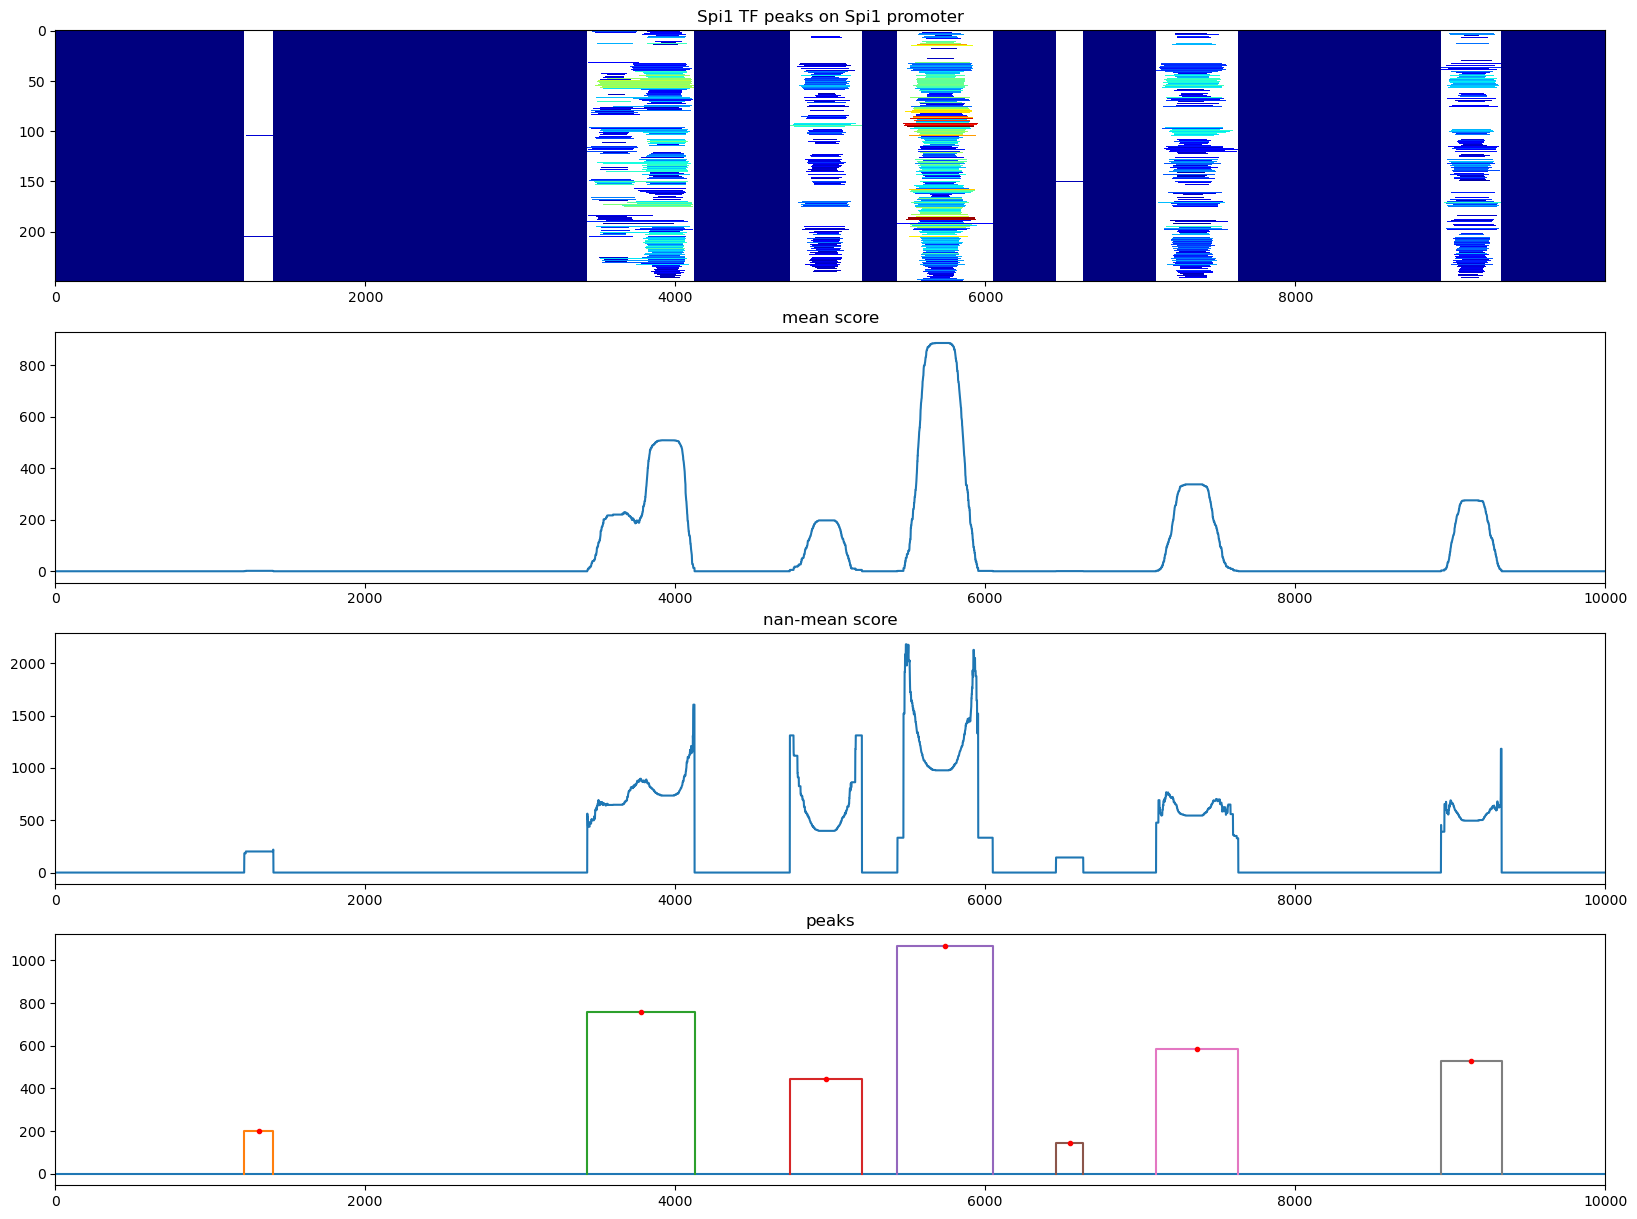

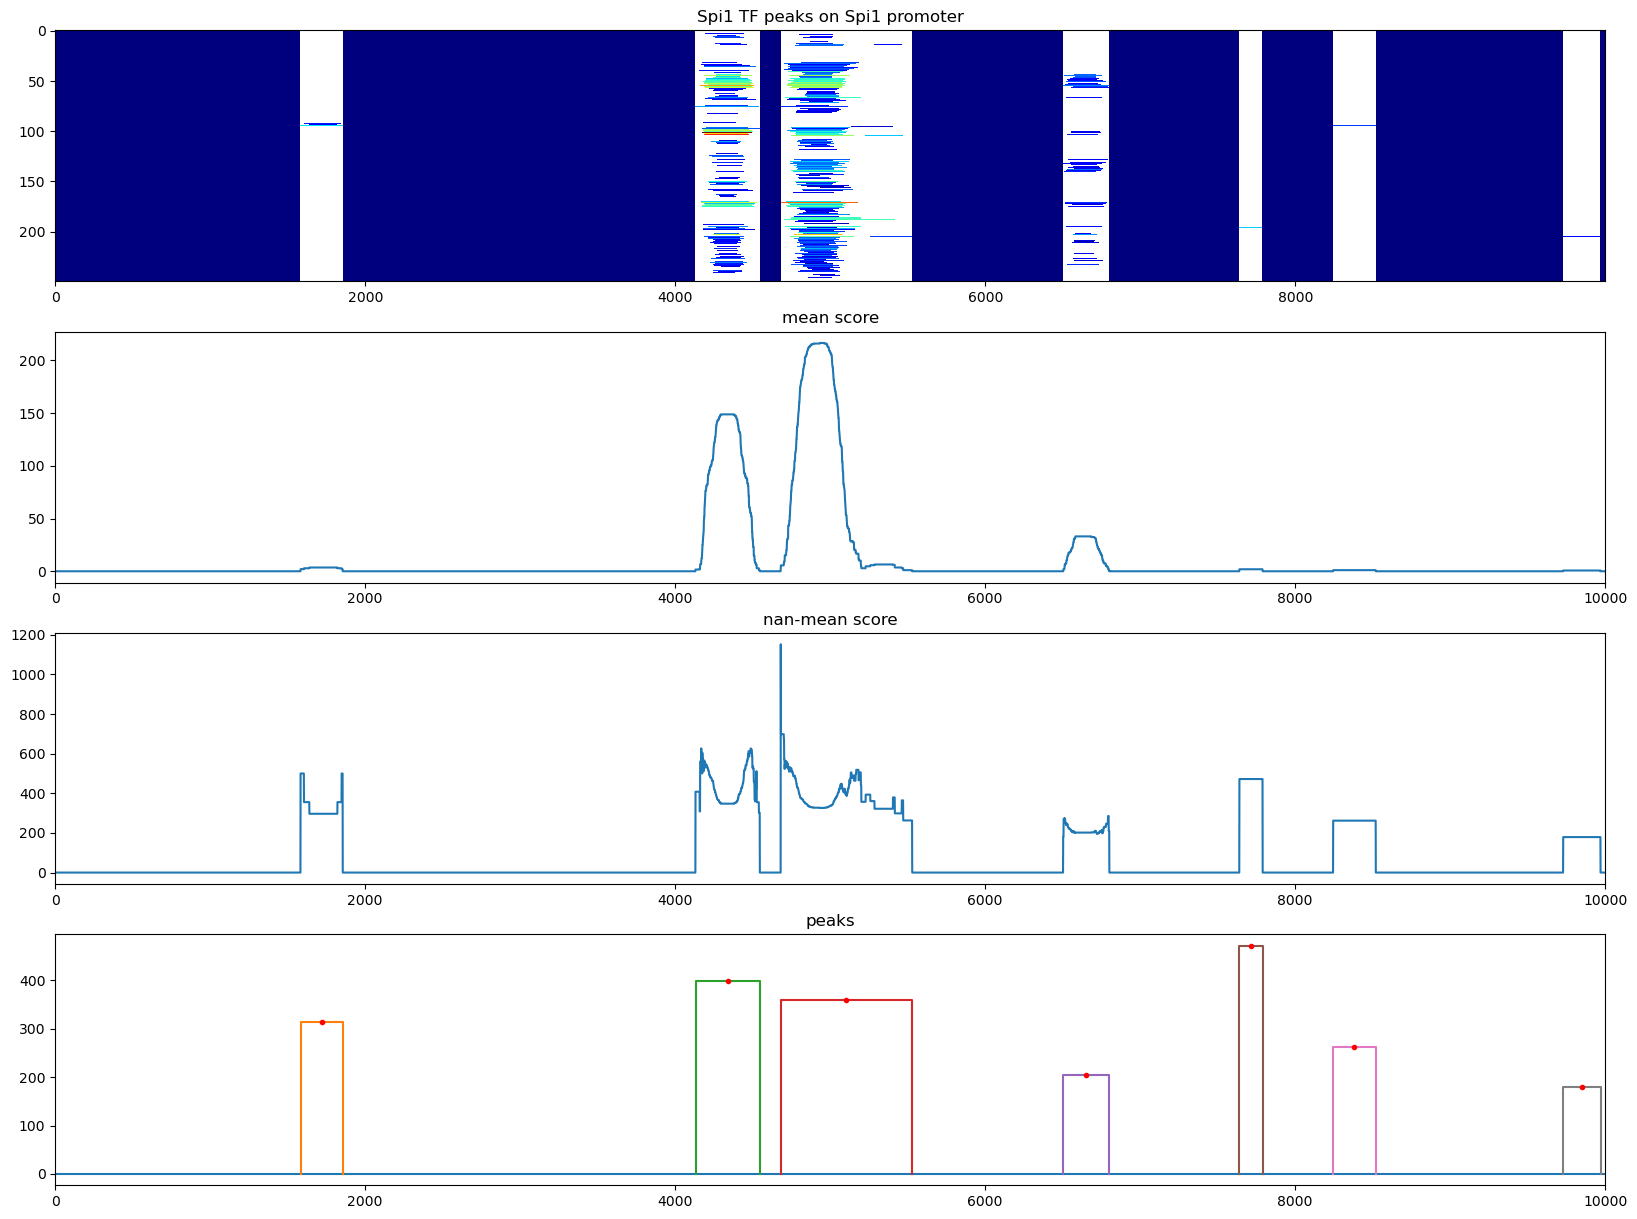

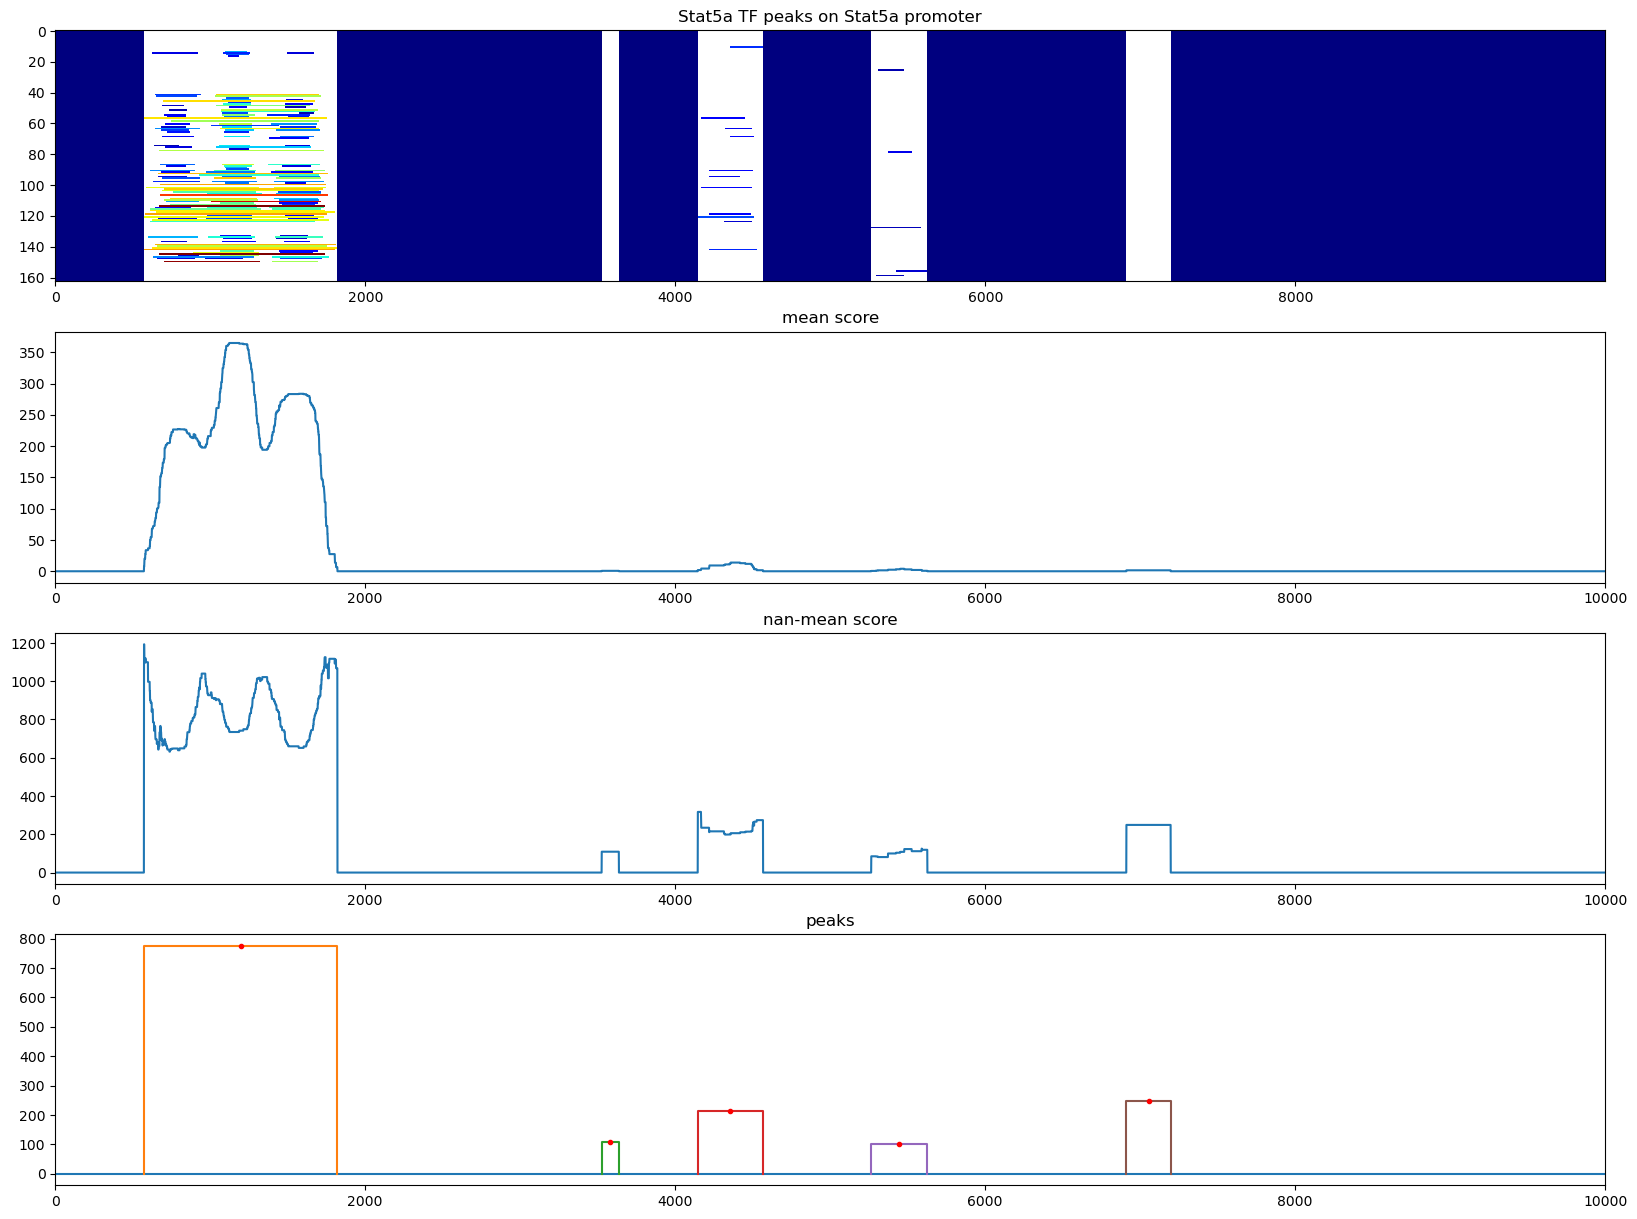

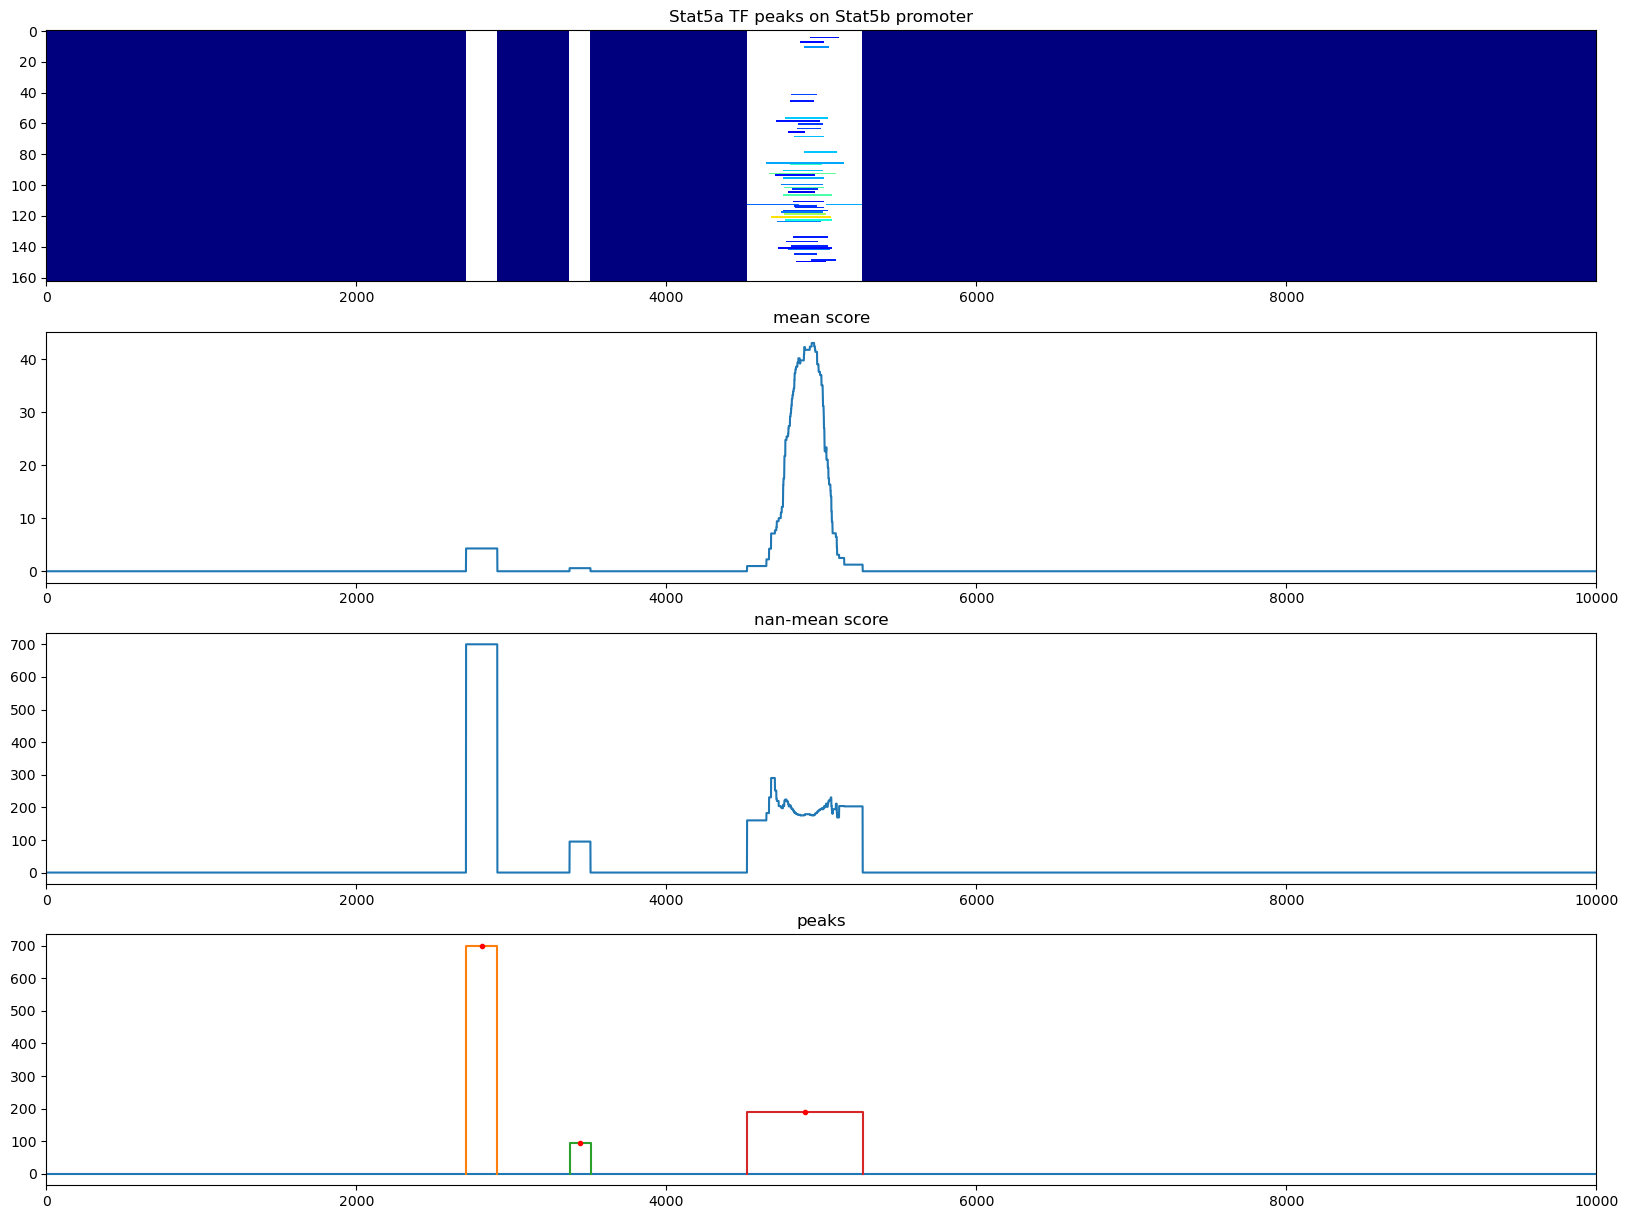

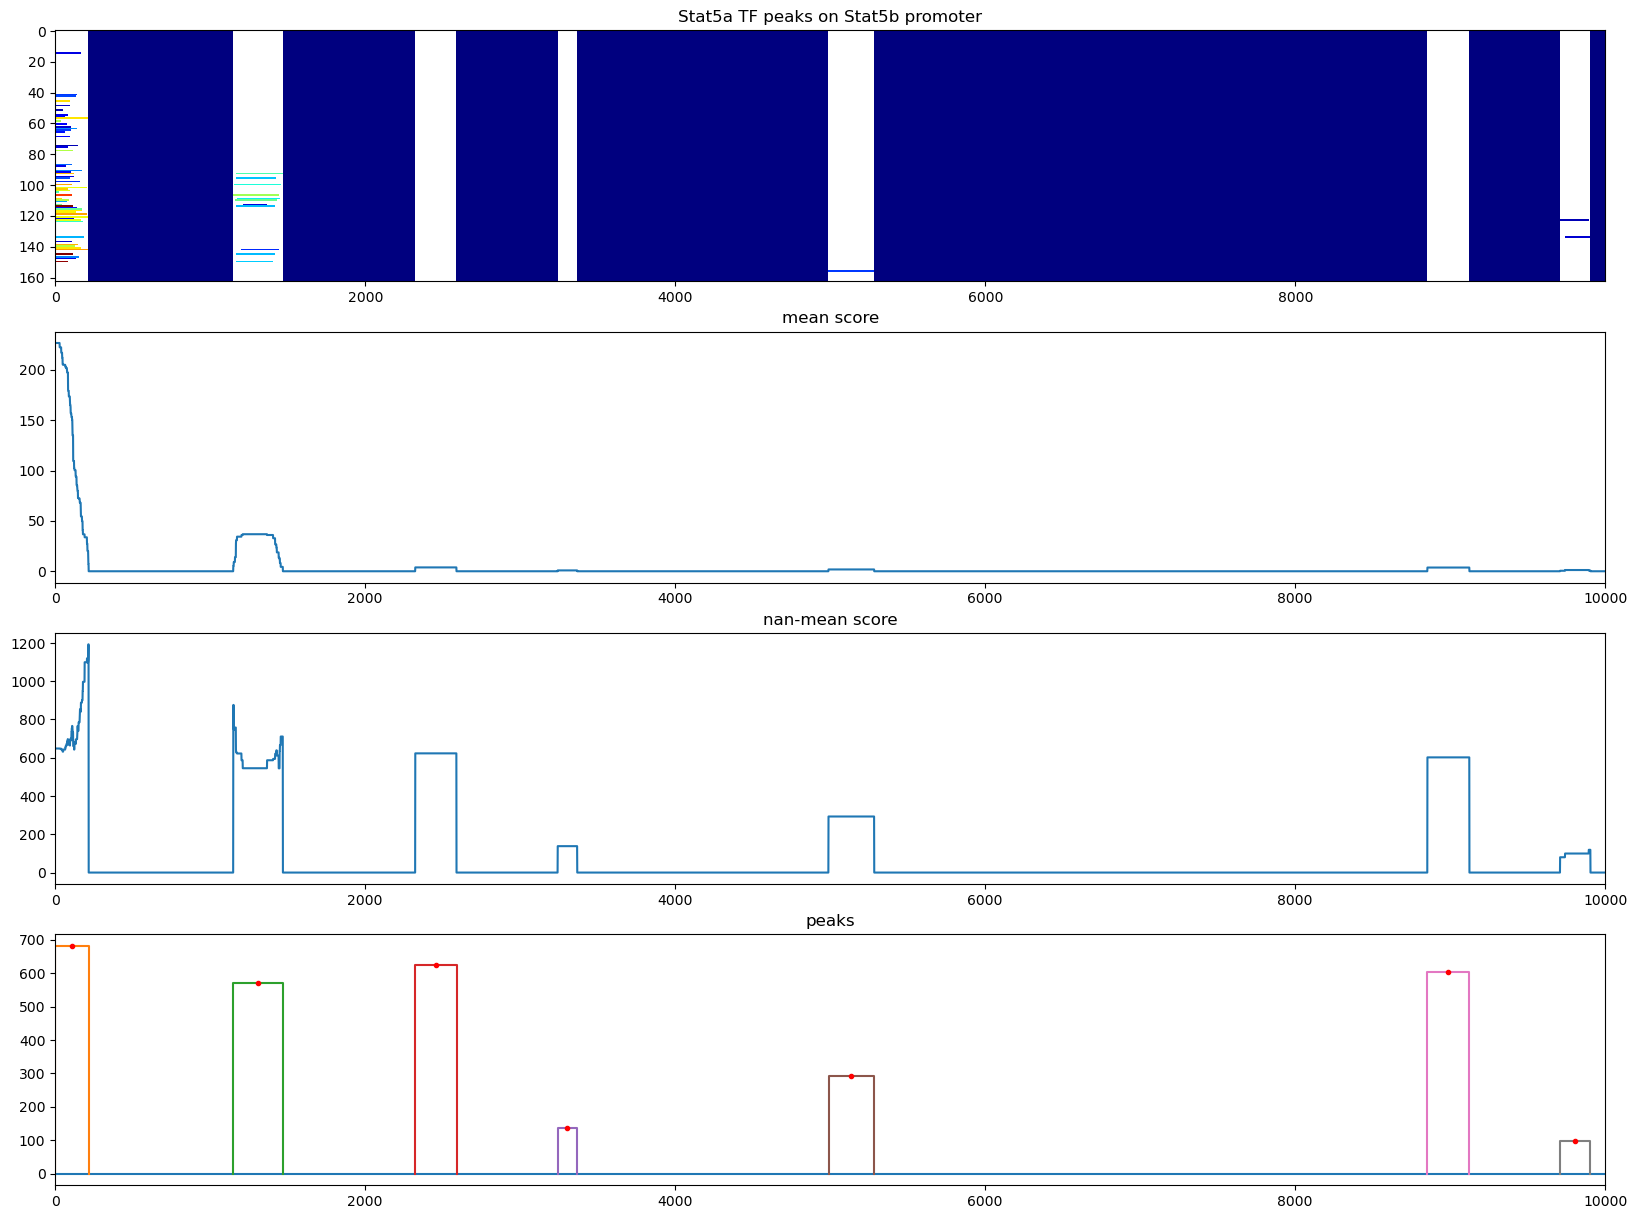

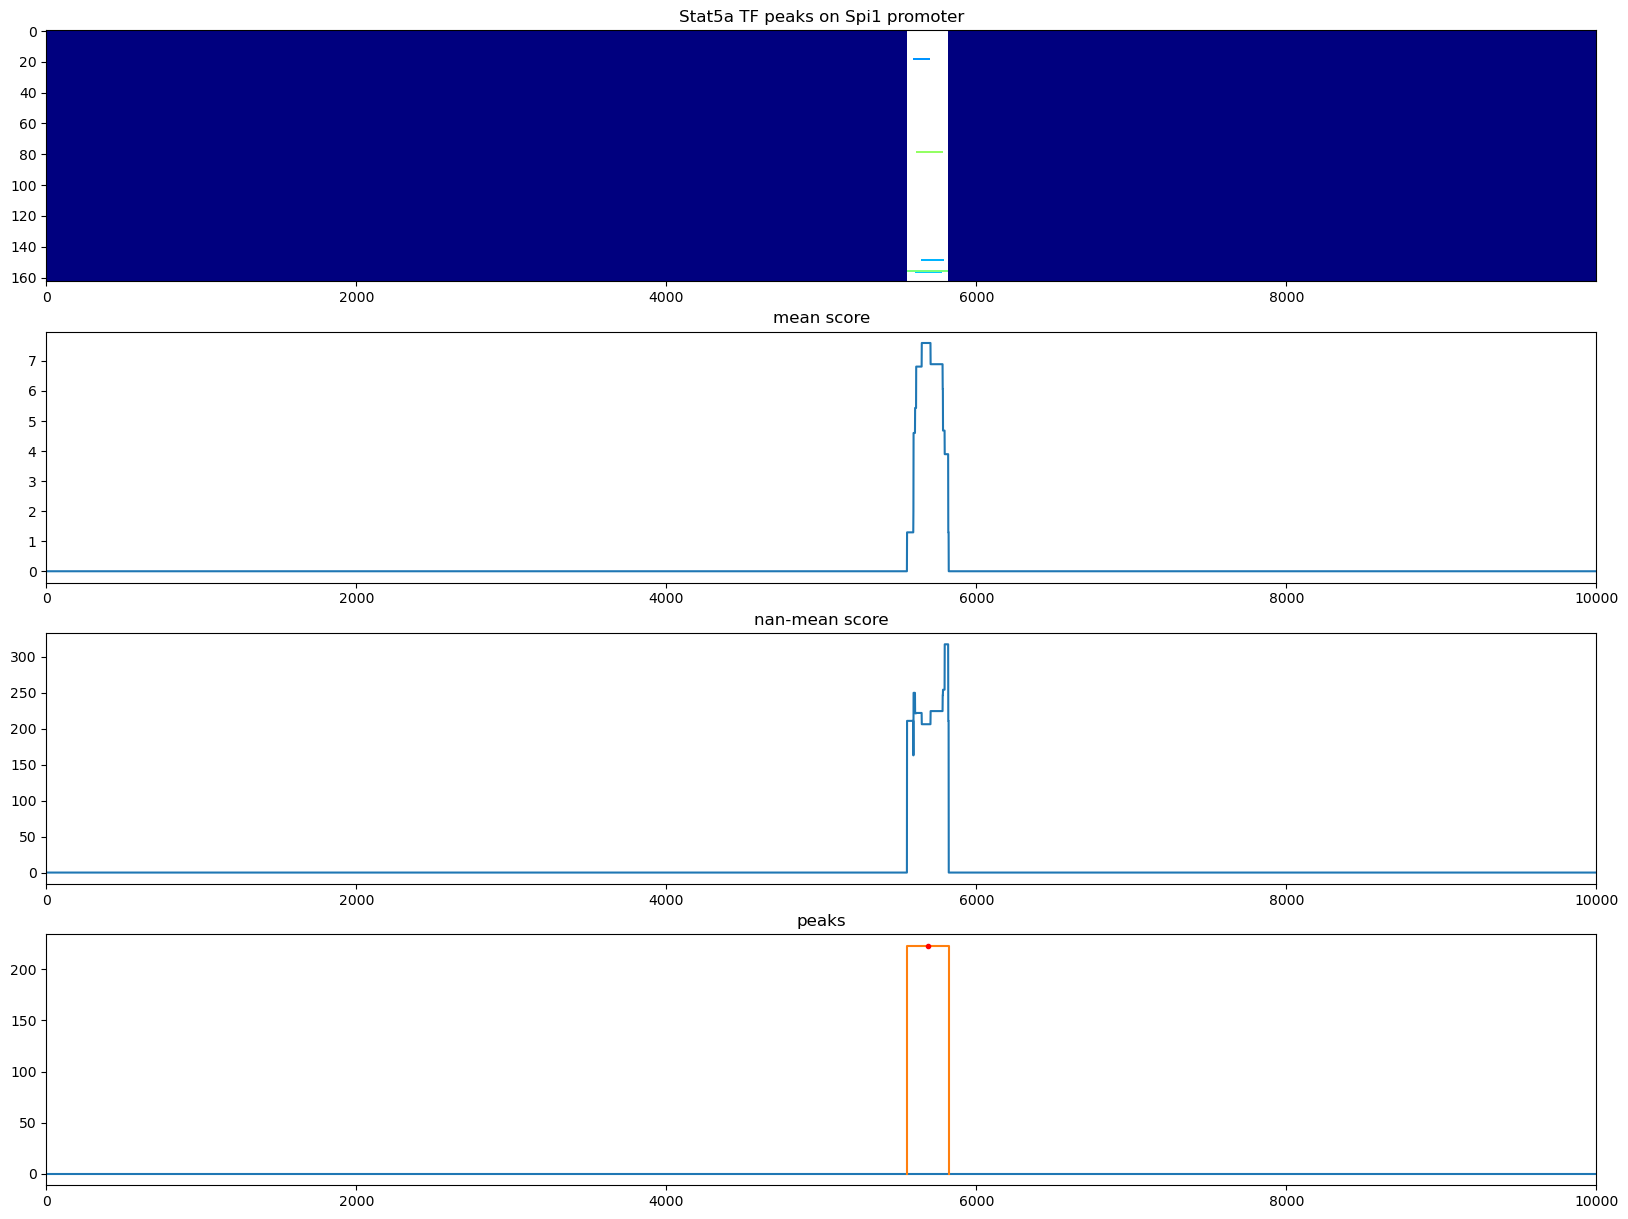

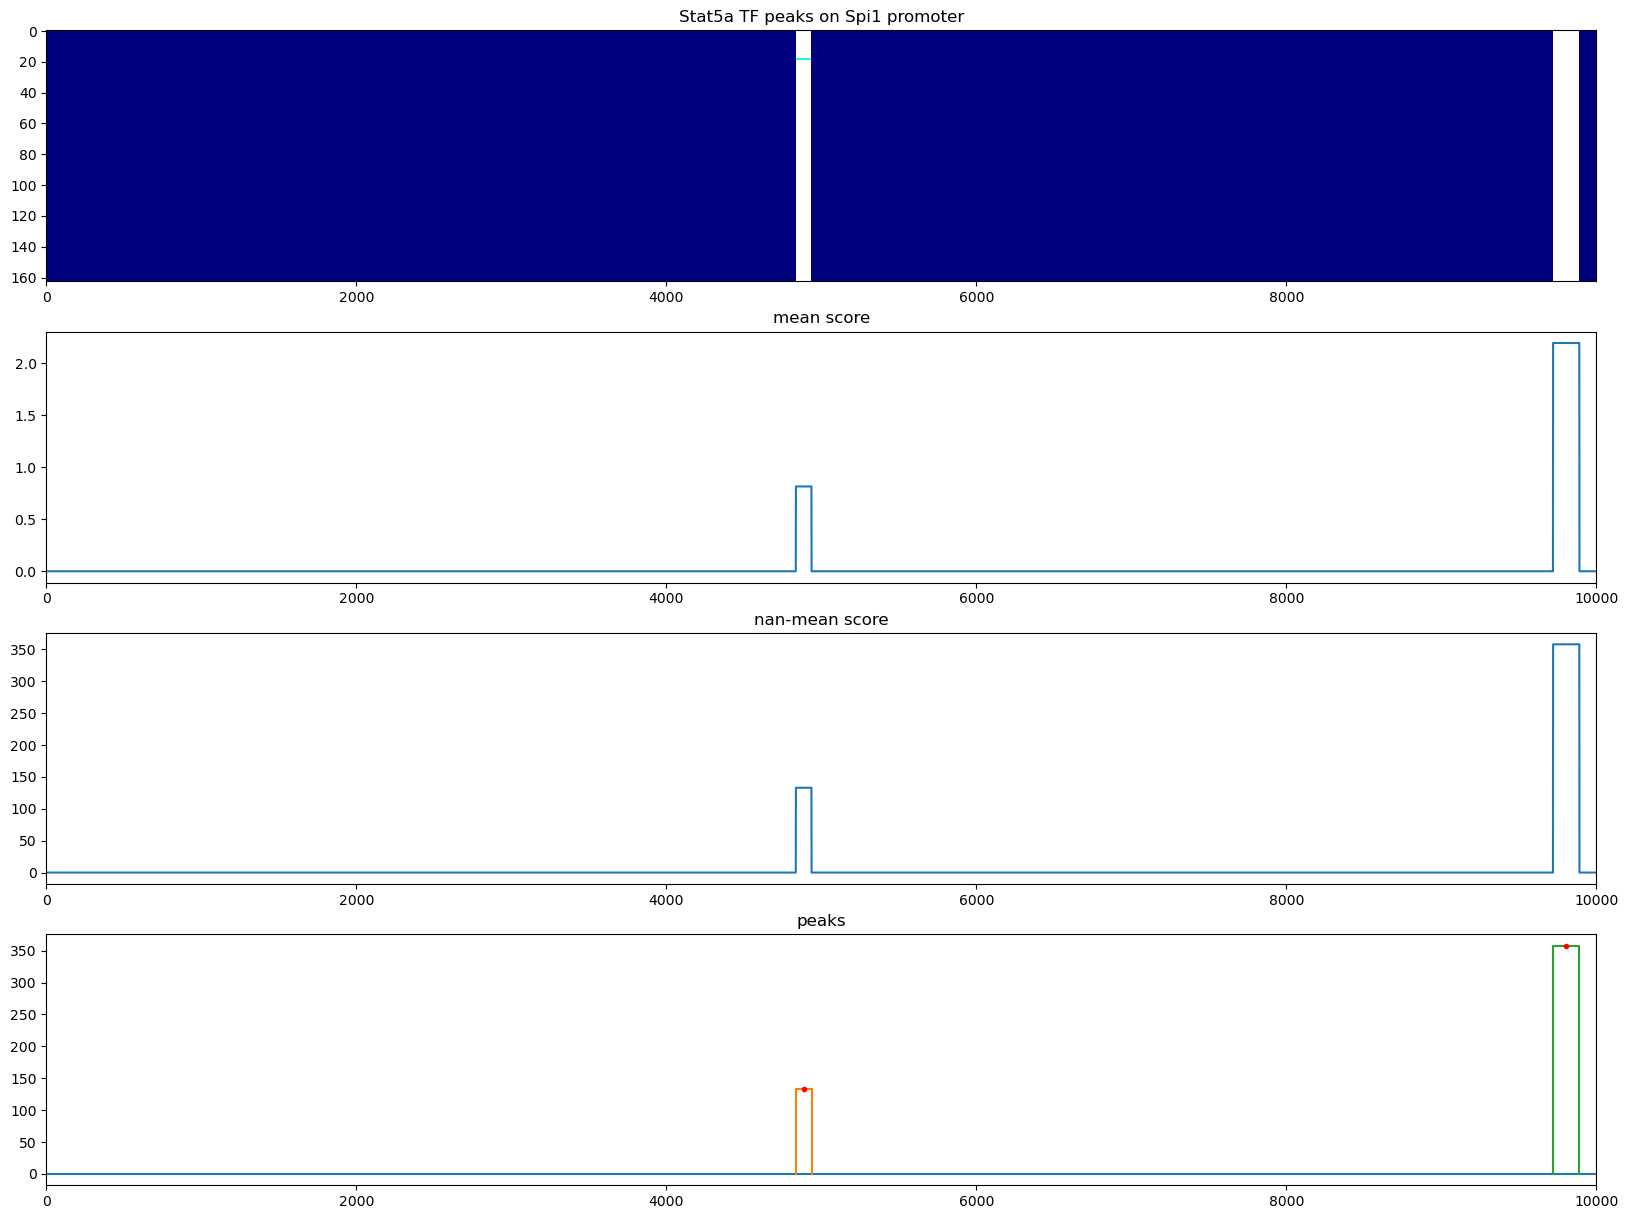

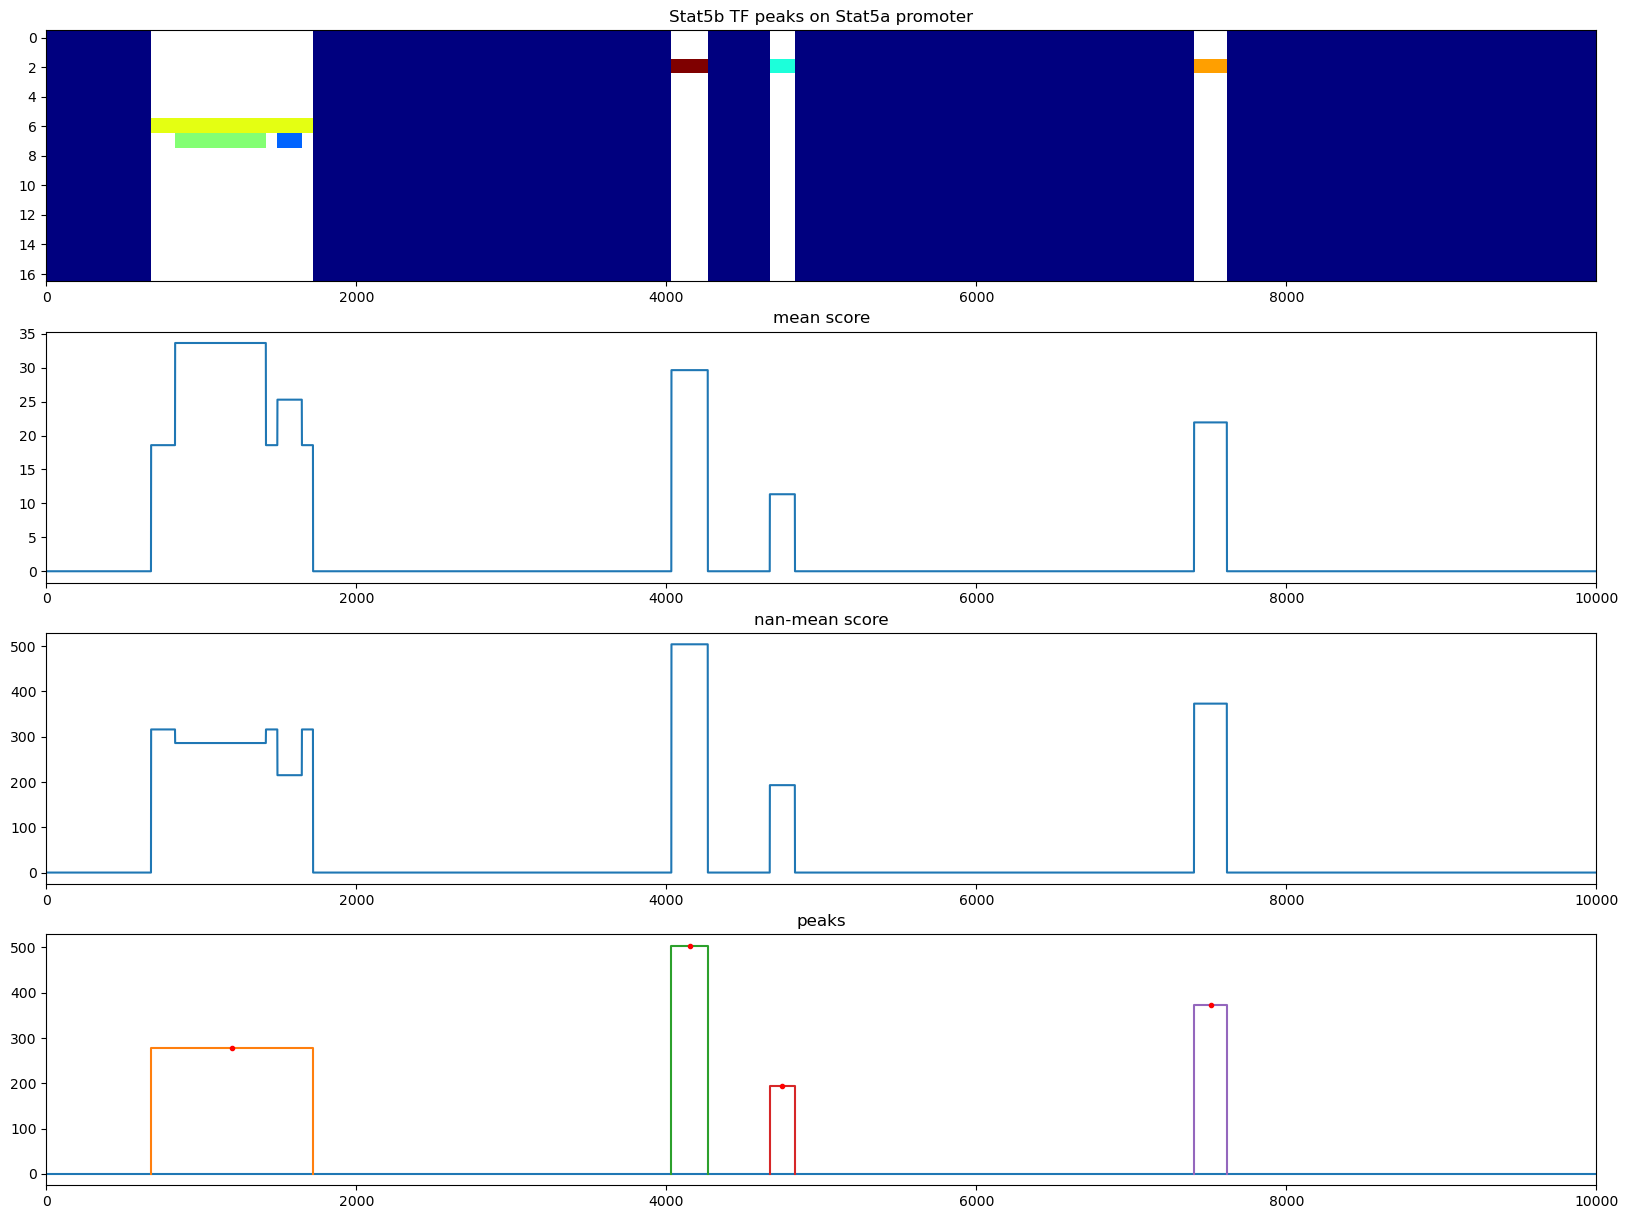

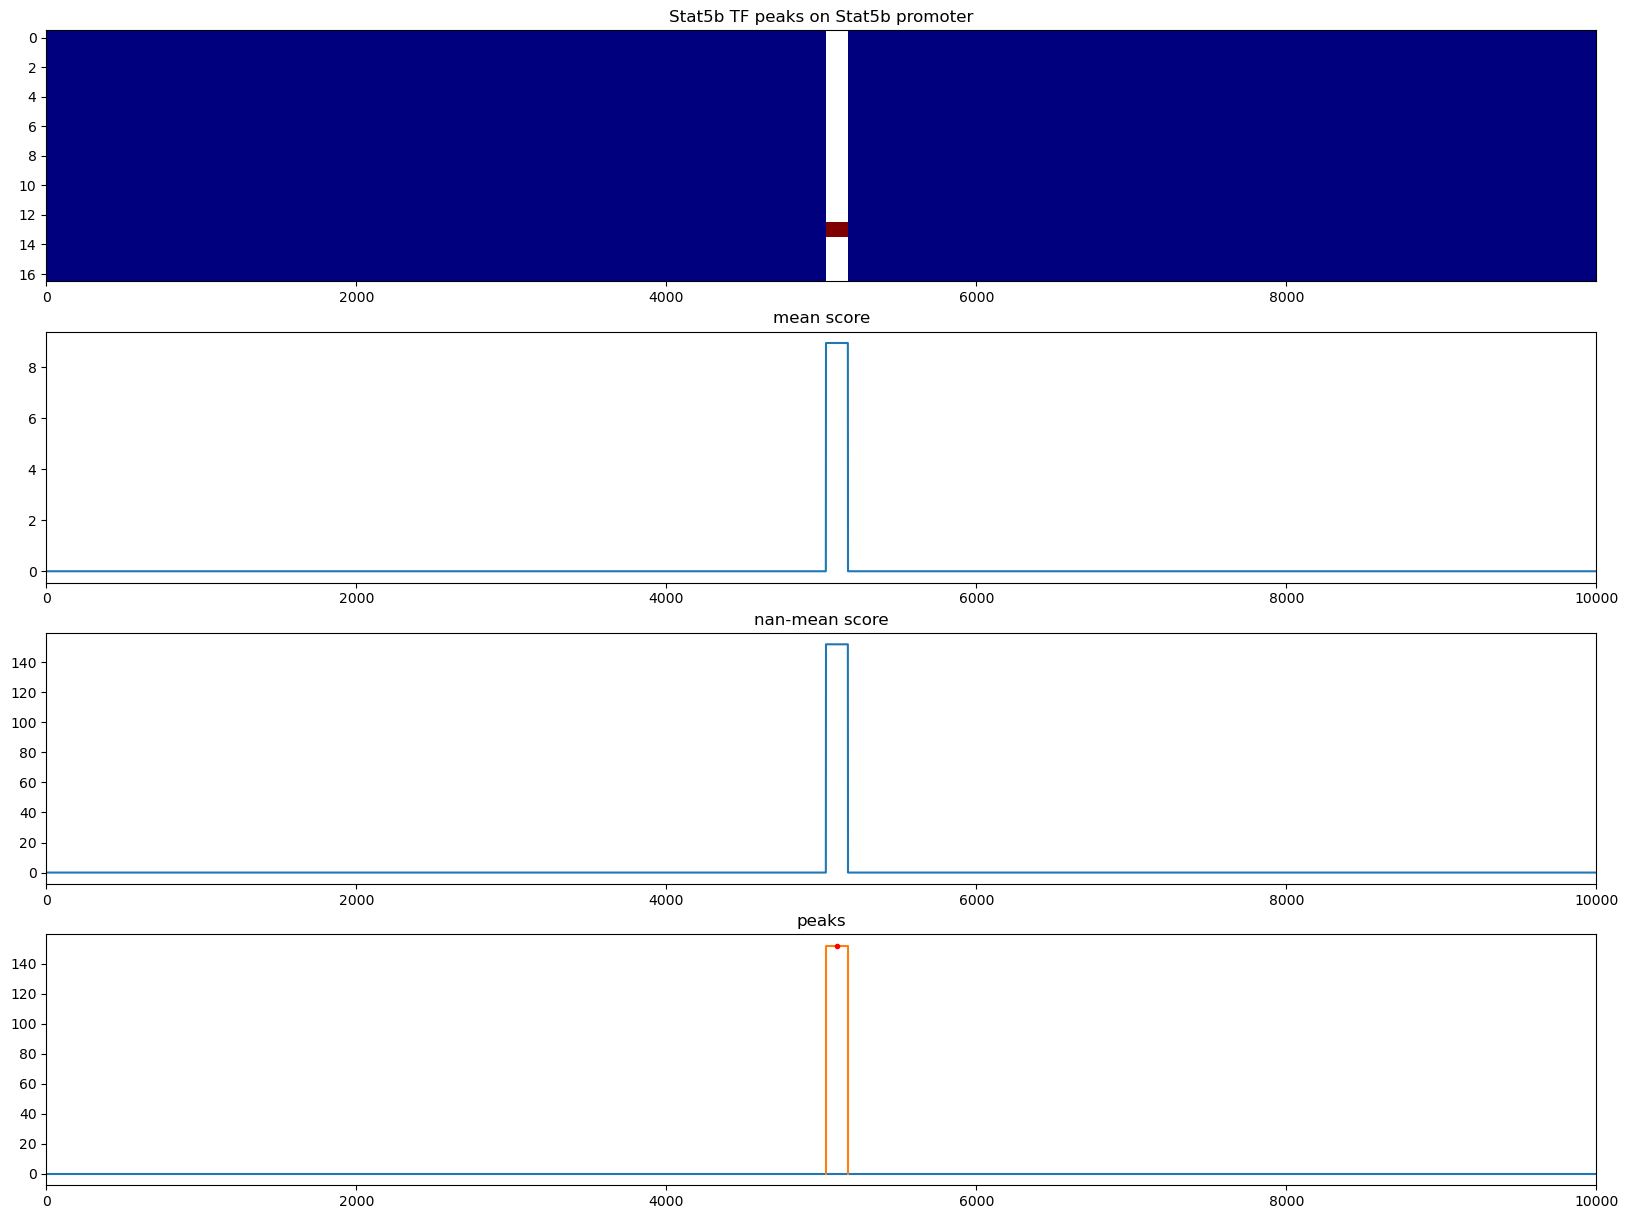

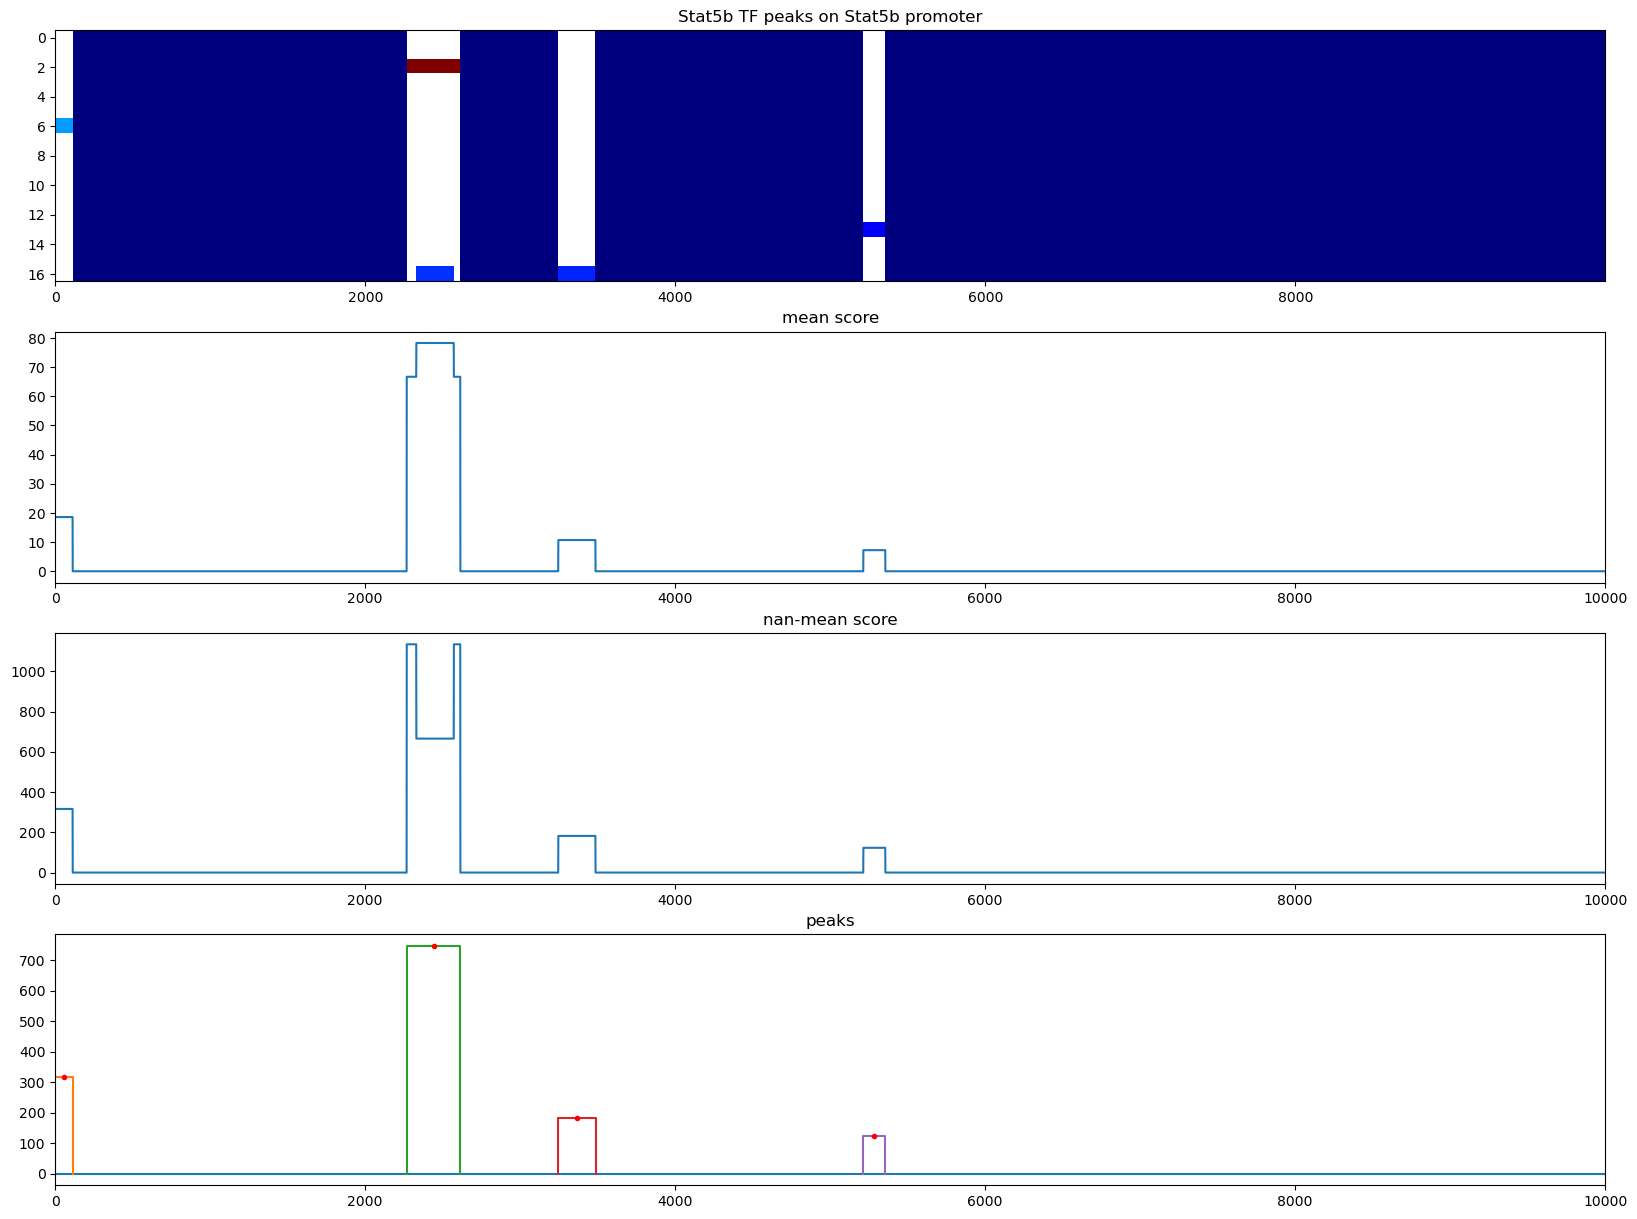

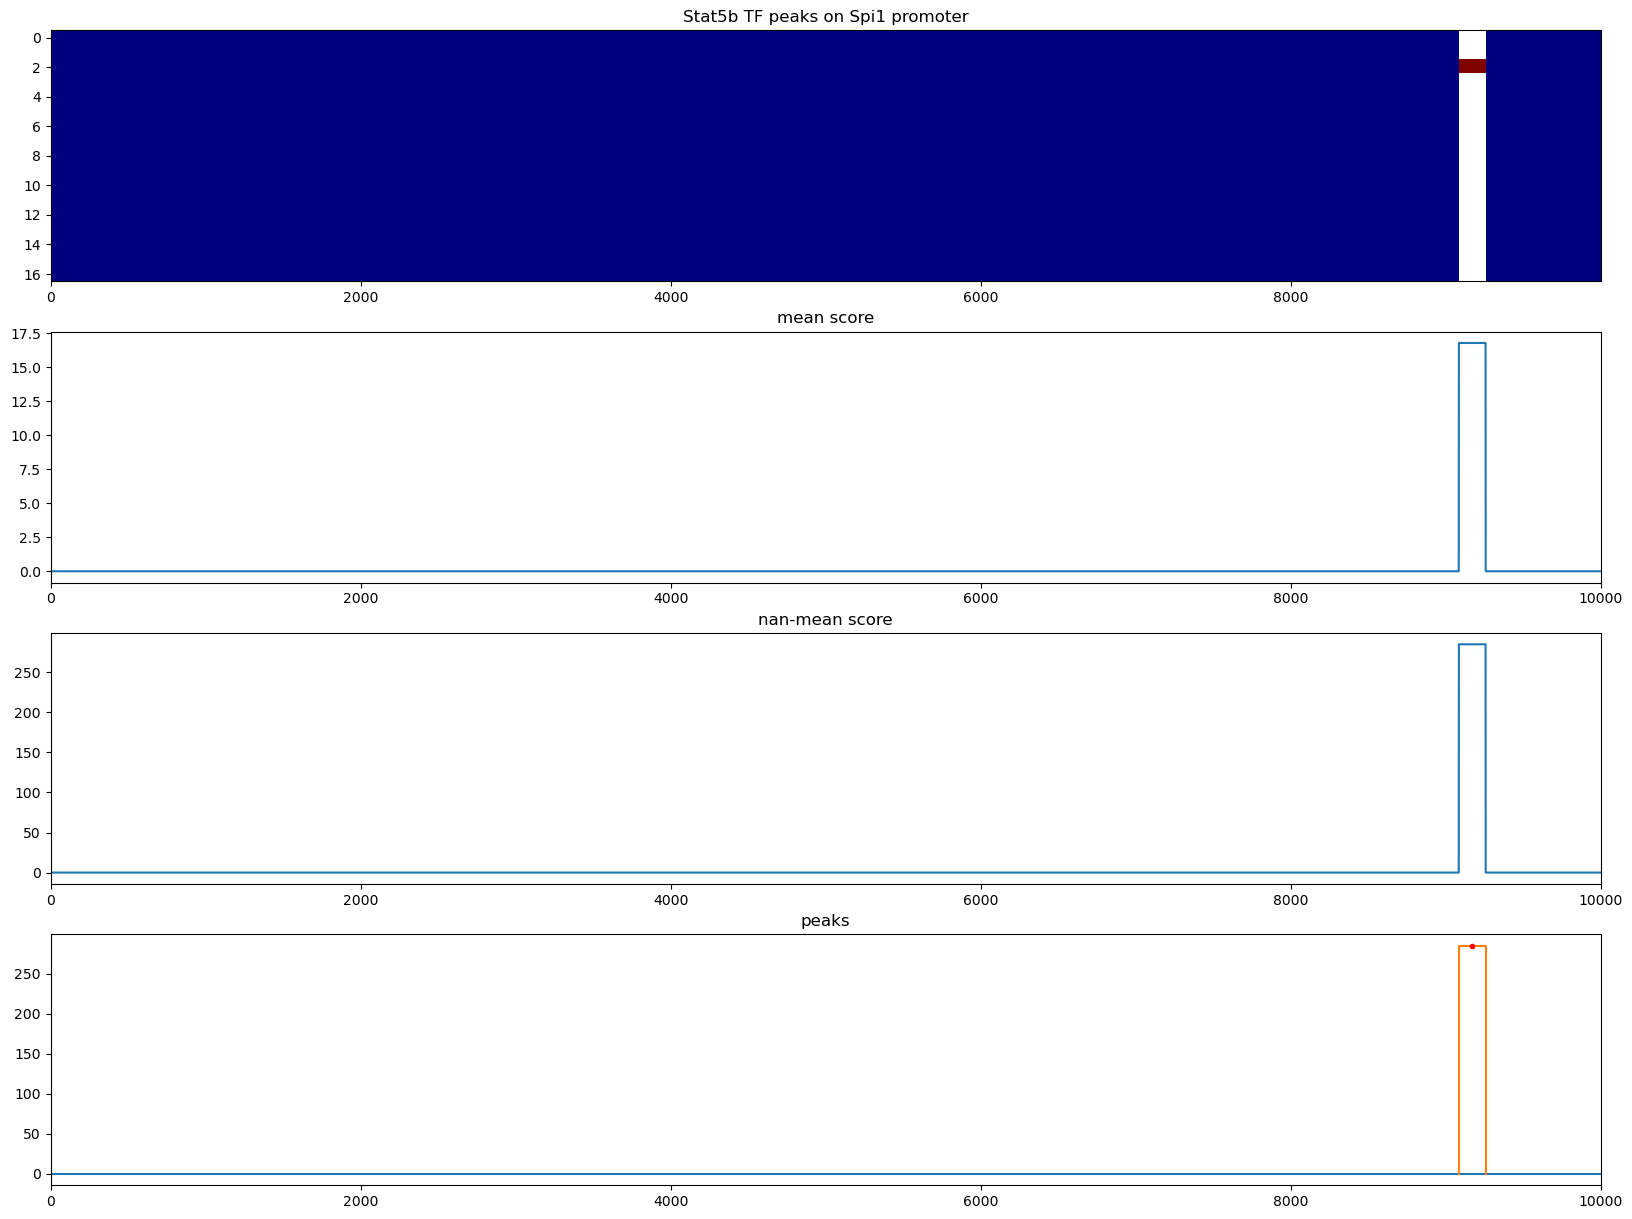

In [7]:
subset = ['Spi1','Stat5a','Stat5b','Essra','Essrb']
short_promoterome = promoterome[promoterome.gene.isin(subset)]

for tf in subset:
    IDs = list(experiment_tf.loc[experiment_tf.antigen==tf,'id'])

    for prom in short_promoterome.index:
        [chr,start,end,strand] = short_promoterome.loc[prom,['chr','start','end','strand']].values

        score = np.zeros([len(IDs),window_kb*2*1000])*np.nan
        for exp,id in enumerate(IDs):
            infile = f"../resources/tracks/mm10/{id}.05.bb"
            with pyBigWig.open(infile) as bb:
                if not chr in bb.chroms():
                    continue
                
                entries = bb.entries(chr, start, min(end,bb.chroms(chr)))
                if entries == None:
                    continue
                
                for e in entries:
                    score[exp,(e[0]-start):(e[1]-start)] = int(e[2])

        if np.isnan(score).all():
            continue

        if strand == '-':
            score = score[:,::-1]

        peak_idx = np.where(np.any(~np.isnan(score),0))[0]
        dp = np.diff(peak_idx)
        dp = np.insert(dp,0,0)
        dp = np.append(dp,0)
        ends = peak_idx[dp[1:] != 1]
        starts = peak_idx[dp[:-1] != 1]
        peaks = np.concatenate([starts.reshape(-1,1),ends.reshape(-1,1)],1)
        # add 1 to ends to make it half open
        peaks[:,1] += 1
        # add 2 columns of zeros for the score and the distance to tss
        peaks = np.concatenate([peaks,np.zeros([peaks.shape[0],2])],1).astype(int)
        for p,peak in enumerate(peaks):
            peaks[p,2] = np.nanmean(score[:,peak[0]:peak[1]])
            peaks[p,3] = (peak[0]+peak[1])/2
        
        if True:
            score[:,np.all(np.isnan(score),0)] = 0
            score_smooth = score.copy()
            score_smooth[np.isnan(score_smooth)] = 0
        
            fig, ax = plt.subplots(4,1,figsize=(20,15))

            ax[0].imshow(score,aspect='auto',cmap='jet',interpolation='none')
            ax[0].set_title(f'{tf} TF peaks on {short_promoterome.loc[prom,'gene']} promoter')

            ax[1].plot(np.mean(score_smooth,0))
            ax[1].set_xlim([0,window_kb*2*1000])
            ax[1].set_title('mean score')

            
            ax[2].plot(np.nanmean(score,0))
            ax[2].set_xlim([0,window_kb*2*1000])
            ax[2].set_title('nan-mean score')

            ax[3].plot([0,window_kb*2*1000],[0,0])
            for peak in peaks:
                ax[3].plot([peak[0],peak[0],peak[1],peak[1]],[0,peak[2],peak[2],0])
                ax[3].plot(peak[3],peak[2],'r.')
            ax[3].set_xlim([0,window_kb*2*1000])
            ax[3].set_title('peaks')



## parallelization

In [31]:
# get the peak positions of the TFs in the promoters
def find_tf_peaks_in_promoter(promoterome,experiment_tf,window_kb,tf_i):
    tf = tf_i[0]
    i = tf_i[1]
    # get TF IDs
    IDs = list(experiment_tf.loc[experiment_tf.antigen==tf,'id'])

    IJKval = np.zeros([4,0]) # n_dim (i,j,k,val) x n_peaks with i=TF, j=promoter, k=position, val=score

    # loop over all promoters
    for j,prom in enumerate( promoterome.index ): 
        # get promoter coordinates
        [chr,start,end,strand] = promoterome.loc[prom,['chr','start','end','strand']].values

        # initialize score matrix (n_experiments x window size)
        score = np.zeros([len(IDs),window_kb*2*1000])*np.nan

        # loop over all experiments
        for l,id in enumerate(IDs):
            infile = f"../resources/tracks/mm10/{id}.05.bb"
            with pyBigWig.open(infile) as bb:
                # check if the chromosome is in the bigwig file and get the entries
                if not chr in bb.chroms():
                    continue
                entries = bb.entries(chr, start, min(end,bb.chroms(chr)))
                if entries == None:
                    continue

                # fill in the score matrix with the score of the experiment at the peak relative positions
                for e in entries:
                    score[l,(e[0]-start):(e[1]-start)] = int(e[2])

        # if there are no peaks for this TF in this promoter, skip
        if np.isnan(score).all():
            continue

        # flip the score matrix if the promoter is on the negative strand
        if strand == '-':
            score = score[:,::-1]

        # find the peak positions in the score matrix
        peak_idx = np.where(np.any(~np.isnan(score),0))[0]
        # find the start and end of the peaks
        dp = np.diff(peak_idx)
        dp = np.insert(dp,0,0)
        dp = np.append(dp,0)
        ends = peak_idx[dp[1:] != 1]
        starts = peak_idx[dp[:-1] != 1]
        peaks = np.concatenate([starts.reshape(-1,1),ends.reshape(-1,1)],1)
        # add 1 to ends to make it half open
        peaks[:,1] += 1
        # get the score and position and save in Peaks matrix
        for peak in peaks:
            mean_score = np.nanmean(score[:,peak[0]:peak[1]])
            k = int((peak[0]+peak[1])/2)
            ijkval = np.array([i,j,k,mean_score])[:,None]
            IJKval = np.concatenate([IJKval,ijkval],1)

        
    return IJKval

subset = TFs[:10]
short_promoterome = promoterome[promoterome.gene.isin(subset)]

TF_IDX = np.concatenate([subset[:,None],np.arange(len(subset))[:,None]],1)

with Pool(processes=24) as pool:
    OUT = pool.map(partial(find_tf_peaks_in_promoter,short_promoterome,experiment_tf,window_kb), TF_IDX)
IJKval = np.zeros([4,0])
for i,out in enumerate(OUT):
    IJKval = np.concatenate([IJKval,out],1)

# make sparse tensor
indices = IJKval[:3].astype(int)
values = IJKval[3]
my_size = [short_promoterome.shape[0],TFs.shape[0],window_kb*2*1000]
PromTfPos = torch.sparse_coo_tensor(indices, values, size=my_size)

# save tensor
outfile = "../tmp/PromTfPos.pt"
torch.save(PromTfPos,outfile)

In [30]:
print(IJKval.shape)
t = 92
print( t/TFs.shape[0]*promoterome.shape[0]/3600 )

(4, 103)
1.468632679738562


Nr5a1
Sall1
Gata3
Irf8
Nfe2l2
Prdm14
Spi1
Heyl
Sox9
Smad1
Kdm2b
Runx1
Dbp
Nfil3
Rela
Runx3
Atf7
Irf4
Mecp2
Xbp1
Bcl11a
Cebpa
Hnf4a
Foxa1
Bcl6
Foxp2
Dnmt1
Tet3
Pparg
Rxra
Nanog
Pou5f1
Tcf3
Tal1
Gata1
Setdb1
Mtf2
Cxxc1
Kdm2a
Crx
Srf
Rara
Ebf1
Foxa2
E2f4
Cebpb
Ctcf
Nr1h2
Stat3
Nr3c1
Esr1
Stat4
Stat6
Foxo1
Tbp
Med1
Smad3
Myod1
Cdx2
Myf5
Tet1
Pax7
Pax3
Yy1
Nfya
Gata2
Stat5a
Arntl
Fli1
Stat5b
Rest
Ptf1a
Cebpd
Sox2
Ets1
Gtf2b
Rbpj
Olig2
Rarg
Tcf7
Gfi1
Esrrb
Mbd3
Tcf7l1
Kdm5b
Jun
Ikzf3
Ikzf1
Meis1
Klf15
Nr1d1
Foxl2
Six1
Klf4
Batf
Kmt2a
Klf5
Sox3
Sox11
Fos
Zfp57
Etv2
Satb2
Isl1
Trp53
Gfi1b
Elk4
Vdr
Esr2
Gata6
Sox5
Sox6
Ascl1
Creb1
Prrx1
Rag1
Otx2
Erg
Lyl1
Pou3f2
E2f3
Zfp541
Egr1
Mef2c
Sox10
Tbx21
Shox2
Bhlhe40
Ctcfl
Stat1
Npas3
Hoxb4
Smad4
Nr1d2
Pax5
Nkx2-2
Nkx6-1
Clock
Pdx1
Ncoa3
Baz2a
Ebf2
Hoxa9
Egr2
Nr5a2
Arid5a
Hnf1b
Pgr
Tfeb
Tbr1
Myc
Lhx6
Prdm1
Hsf1
Grip1
Prdm16
Nr1h3
Ppara
Tcf4
Neurod2
Sox4
Myt1l
Peg3
Rfx1
Foxp3
Tbx3
Gata4
Ahr
Glis3
Nfia
Ddit3
Atf4
Emx2
Pax6
Hsf2
Nkx3-1
Mesp1
Zic2
Zic3
Cu

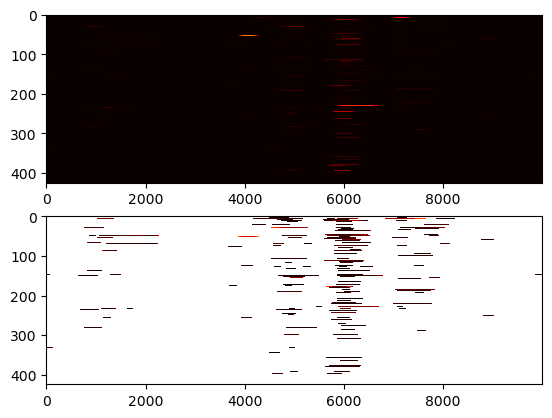

In [68]:
my_prom = 'Stat5a'

SCORE = np.zeros([len(TFs),window_kb*2*1000])
SCORE_nanmean = np.zeros([len(TFs),window_kb*2*1000])*np.nan
for t,tf in enumerate(TFs):
    print(tf)
    p = promoterome[promoterome.gene == my_prom].index
    [chr,start,end,strand] = promoterome.loc[p,['chr','start','end','strand']].values[0]

    IDs = list(experiment_tf.loc[experiment_tf.antigen==tf,'id'])
    score = np.zeros([len(IDs),window_kb*2*1000])*np.nan

    for i,id in enumerate(IDs):
        infile = f"../resources/tracks/mm10/{id}.05.bb"
        with pyBigWig.open(infile) as bb:
            if not chr in bb.chroms():
                continue
            
            entries = bb.entries(chr, start, min(end,bb.chroms(chr)))
            if entries == None:
                continue
            
            for e in entries:
                score[i,(e[0]-start):(e[1]-start)] = int(e[2])

    if strand == '-':
        score = score[:,::-1]
    
    idx = np.any(~np.isnan(score),0)
    SCORE_nanmean[t,idx] = np.nanmean(score[:,idx],axis=0)

    score[np.isnan(score)] = 0
    SCORE[t,:] = np.mean(score,axis=0)
            

fig, ax = plt.subplots(2,1)
ax[0].imshow(SCORE,aspect='auto',cmap='hot',interpolation='none')
ax[1].imshow(SCORE_nanmean,aspect='auto',cmap='hot',interpolation='none')


/tmp/ipykernel_29663/4028719874.py:2: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(SCORE_nanmean,0))


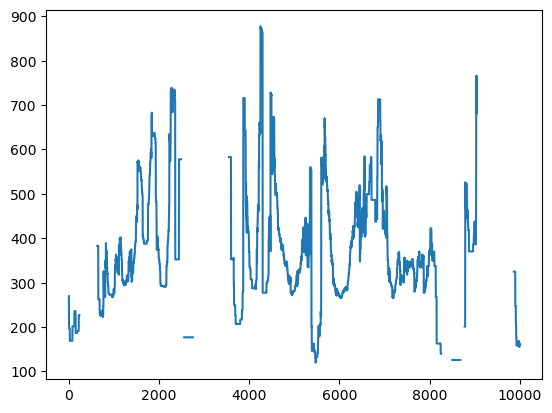

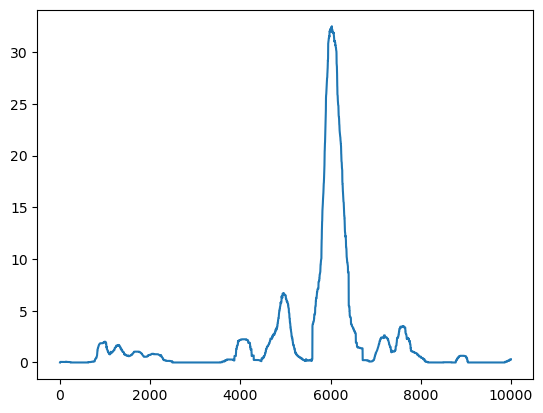

In [69]:
fig, ax = plt.subplots(1,1)
ax.plot(np.nanmean(SCORE_nanmean,0))

fig, ax = plt.subplots(1,1)
ax.plot(np.mean(SCORE,0))

Nr5a1
Sall1
Gata3


Irf8
Nfe2l2
Prdm14
Spi1
Heyl
Sox9
Smad1
Kdm2b
Runx1
Dbp
Nfil3
Rela
Runx3
Atf7
Irf4
Mecp2
Xbp1
Bcl11a
Cebpa
Hnf4a
Foxa1
Bcl6
Foxp2
Dnmt1
Tet3
Pparg
Rxra
Nanog
Pou5f1
Tcf3
Tal1
Gata1
Setdb1
Mtf2
Cxxc1
Kdm2a
Crx
Srf
Rara
Ebf1
Foxa2
E2f4
Cebpb
Ctcf
Nr1h2
Stat3
Nr3c1
Esr1
Stat4
Stat6
Foxo1
Tbp
Med1
Smad3
Myod1
Cdx2
Myf5
Tet1
Pax7
Pax3
Yy1
Nfya
Gata2
Stat5a
Arntl
Fli1
Stat5b
Rest
Ptf1a
Cebpd
Sox2
Ets1
Gtf2b
Rbpj
Olig2
Rarg
Tcf7
Gfi1
Esrrb
Mbd3
Tcf7l1
Kdm5b
Jun
Ikzf3
Ikzf1
Meis1
Klf15
Nr1d1
Foxl2
Six1
Klf4
Batf
Kmt2a
Klf5
Sox3
Sox11
Fos
Zfp57
Etv2
Satb2
Isl1
Trp53
Gfi1b
Elk4
Vdr
Esr2
Gata6
Sox5
Sox6
Ascl1
Creb1
Prrx1
Rag1
Otx2
Erg
Lyl1
Pou3f2
E2f3
Zfp541
Egr1
Mef2c
Sox10
Tbx21
Shox2
Bhlhe40
Ctcfl
Stat1
Npas3
Hoxb4
Smad4
Nr1d2
Pax5
Nkx2-2
Nkx6-1
Clock
Pdx1
Ncoa3
Baz2a
Ebf2
Hoxa9
Egr2
Nr5a2
Arid5a
Hnf1b
Pgr
Tfeb
Tbr1
Myc
Lhx6
Prdm1
Hsf1
Grip1
Prdm16
Nr1h3
Ppara
Tcf4
Neurod2
Sox4
Myt1l
Peg3
Rfx1
Foxp3
Tbx3
Gata4
Ahr
Glis3
Nfia
Ddit3
Atf4
Emx2
Pax6
Hsf2
Nkx3-1
Mesp1
Zic2
Zic3
Cux2
Nrf1
E2f1
Ets2


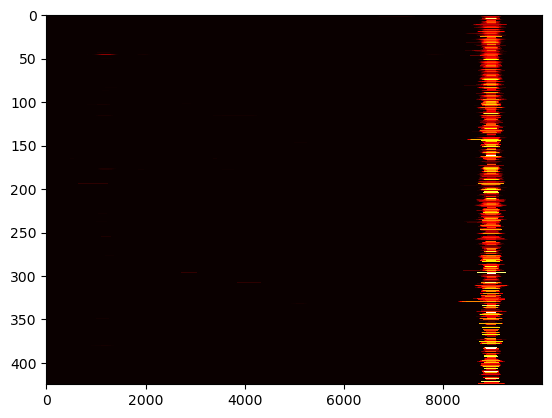

In [51]:
SCORE = np.zeros([len(TFs),window_kb*2*1000])*np.nan
for t,tf in enumerate(TFs):
    print(tf)
    IDs = list(experiment_tf.loc[experiment_tf.antigen==tf,'id'])
    for id in IDs:
        infile = f"../resources/tracks/mm10/{id}.05.bb"
        with pyBigWig.open(infile) as bb:
            p = promoterome[promoterome.gene == 'Tcstv3'].index
            [chr,start,end,strand] = promoterome.loc[p,['chr','start','end','strand']].values[0]
            score = np.zeros([len(IDs),end-start])
            for i,id in enumerate(IDs):
                infile = f"../resources/tracks/mm10/{id}.05.bb"
                with pyBigWig.open(infile) as bb:
                    if chr in bb.chroms():
                        entries = bb.entries(chr, start, min(end,bb.chroms(chr)))
                        if not entries == None:
                            for e in entries:
                                score[i,(e[0]-start):(e[1]-start)] = int(e[2])

            if strand == '-':
                score = score[:,::-1]
            SCORE[t,:] = np.nanmean(score,axis=0)

fig, ax = plt.subplots(1,1)
ax.imshow(SCORE,aspect='auto',cmap='hot',interpolation='none')